Global Health Data Analysis
This Jupyter Notebook performs an in-depth analysis of global health data, focusing on key indicators such as life expectancy, GDP, healthcare infrastructure, and various health metrics. The analysis involves data loading, preprocessing, advanced SQL queries, and comprehensive visualizations to uncover trends and relationships.

That's a great start! To make your Jupyter notebook more readable and effective, we'll break down your code into logical sections, add descriptive Markdown cells, and highlight key insights.

Here's the first part of your formatted Jupyter notebook, covering library imports, setup, and data loading:

Global Health Data Analysis
This Jupyter Notebook performs an in-depth analysis of global health data, focusing on key indicators such as life expectancy, GDP, healthcare infrastructure, and various health metrics. The analysis involves data loading, preprocessing, advanced SQL queries, and comprehensive visualizations to uncover trends and relationships.

1. Setup and Configuration
This section handles the initial setup, including importing necessary libraries, defining custom classes, configuring file paths, and setting up plotting styles for consistent and aesthetically pleasing visualizations.

1.1. Import Libraries and Custom Modules
We import essential libraries for data manipulation (pandas, numpy), database interaction (sqlite3), plotting (matplotlib, seaborn, plotly), and machine learning (sklearn). Additionally, custom classes from the DASC500 module are imported to streamline database management and data analysis tasks.

In [2]:
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Import custom classes
from DASC500.classes.DatabaseManager import DatabaseManager, FileType
from DASC500.classes.DataFrameAnalyzer import ComprehensiveDataFrameAnalyzer
from DASC500.utilities.get_top_level_module import get_top_level_module_path

1.2 Define File Paths and Configure Plotting Style
Here, we set up the input and output directories for our data and results. We also configure matplotlib and seaborn to establish a consistent and enhanced visual style for all plots generated in this notebook. This ensures plots are clear, readable, and professional.

In [3]:
# Set up directories
FOLDER = os.path.join(get_top_level_module_path(), '../..')
INPUT_FOLDER = os.path.join(FOLDER, 'data/DASC501/project')
OUTPUT_FOLDER = os.path.join(FOLDER, 'outputs/DASC501/project')

# Configure advanced plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print("Libraries and custom classes imported successfully.")

# Create a directory for outputs if it doesn't exist
output_dir = OUTPUT_FOLDER
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")

Libraries and custom classes imported successfully.
Directory already exists: D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project


2. Data Loading and Database Management
This section focuses on loading the raw health data from a CSV file into an SQLite database. Utilizing a custom DatabaseManager class ensures robust data handling, including connection management, data loading, and error handling with transaction rollbacks.

2.1 Establish Database Connection and Load Data
We define the paths for our CSV input and the SQLite database output. The DatabaseManager is initialized to connect to the SQLite database. The global_health.csv file is then loaded into a table named health_data within this database. The process includes checks for file existence and verifies data integrity by counting rows and examining the schema after loading.

In [4]:
# Define file paths and table name
csv_file_path = os.path.join(INPUT_FOLDER, "global_health.csv")
db_file_path = os.path.join(OUTPUT_FOLDER, "global_health.db")
table_name = "health_data"

# Initialize DatabaseManager
db_manager = DatabaseManager(db_path=db_file_path)

try:
    db_manager.connect()
    print(f"Successfully connected to database: {db_file_path}")

    # Load data from CSV into the SQLite database using DatabaseManager
    print(f"Loading data from {csv_file_path} into table '{table_name}'...")
    
    # First, check if the CSV file exists
    if not os.path.exists(csv_file_path):
        print(f"Error: CSV file not found at {csv_file_path}")
        raise FileNotFoundError(f"CSV file not found at {csv_file_path}")
    
    # Read the CSV file with pandas first to understand its structure
    print("Reading CSV file with pandas...")
    df = pd.read_csv(csv_file_path)
    print(f"CSV file read successfully. Shape: {df.shape}")
    print(f"Columns in CSV: {df.columns.tolist()}")
    
    # Load data into SQLite
    load_status = db_manager.load_data(
        file_path=csv_file_path,
        table_name=table_name,
        file_type=FileType.CSV,
        clear_table_first=True,
        insert_strategy="INSERT OR REPLACE"
    )

    if load_status:
        print(f"Data from '{csv_file_path}' successfully loaded into table '{table_name}'.")
        db_manager.commit()
        print("Data committed to the database.")
        
        # Verify the table was created by checking its schema
        df_check_schema = db_manager.execute_select_query(f"PRAGMA table_info({table_name});", return_dataframe=True)
        if df_check_schema is not None and not df_check_schema.empty:
            print("\nColumns in the database table:")
            print(df_check_schema[['name', 'type']])
        else:
            print(f"Could not verify columns for table '{table_name}'.")
            
        # Verify data was loaded by counting rows
        row_count_query = f"SELECT COUNT(*) as row_count FROM {table_name};"
        row_count_df = db_manager.execute_select_query(row_count_query, return_dataframe=True)
        if row_count_df is not None and not row_count_df.empty:
            print(f"\nNumber of rows in the database table: {row_count_df['row_count'].iloc[0]}")
        else:
            print("Could not verify row count.")
    else:
        print(f"Failed to load data into table '{table_name}'. Check DatabaseManager logs.")

except Exception as e:
    print(f"An error occurred during data loading: {e}")
    if db_manager and db_manager.conn:
        try:
            db_manager.rollback()
            print("Transaction rolled back due to error during data loading.")
        except Exception as rb_e:
            print(f"Error during rollback: {rb_e}")
finally:
    if db_manager and db_manager.conn:
        db_manager.close()
        print("Database connection closed after initial load attempt.")

2025-06-06 13:36:24,539 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:65 - DatabaseManager initialized for DB: 'D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_health.db'
2025-06-06 13:36:24,539 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:101 - Connecting to database: 'D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_health.db'...
2025-06-06 13:36:24,541 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:105 - Database connection established successfully.
Successfully connected to database: D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_health.db
Loading data from D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\data/DASC501/project\global_health.csv into table 'health_data'...
Reading CSV file with pandas...
CSV file 

3. Advanced SQL Explorations
This section leverages the power of SQL to perform targeted queries directly on our SQLite database. These queries are designed to extract specific insights and summary statistics that lay the groundwork for more detailed analysis and visualization.

3.1 Execute Targeted SQL Queries
We run five distinct SQL queries to explore various aspects of the global health data:

- Dataset Scope Summary: Counts distinct countries and years, providing the temporal range of the dataset.
- Life Expectancy Trends by Region: Calculates the average life expectancy over time, grouped by a simplified regional classification.
- Correlation with Life Expectancy: Determines the correlation coefficients between life expectancy and key indicators like GDP per capita, hospital beds, water access, immunization rates, and sanitary expenses.
- Gender Gap in Life Expectancy: Identifies countries with the largest gender disparities in life expectancy.
- Obesity vs. Life Expectancy: Finds countries that exhibit both high obesity rates and high life expectancy, indicating potential paradoxes.

In [5]:
try:
    db_manager.connect()
    print("\n--- Advanced SQL Exploration Results ---")

    # Query 1: Count distinct countries and years
    query1 = f"""
    SELECT
        COUNT(DISTINCT Country) as DistinctCountries,
        COUNT(DISTINCT Year) as DistinctYears,
        MIN(Year) as StartYear,
        MAX(Year) as EndYear
    FROM {table_name};
    """
    print("\nQuery 1: Dataset scope summary")
    result1 = db_manager.execute_select_query(query1, return_dataframe=True)
    print(result1)

    # Query 2: Life expectancy trends over time by continent (using regional proxies)
    query2 = f"""
    WITH RegionalCountries AS (
        SELECT Country,
        CASE
            WHEN Country IN ('United States', 'Canada', 'Mexico') THEN 'North America'
            WHEN Country IN ('Brazil', 'Argentina', 'Chile', 'Colombia', 'Peru') THEN 'South America'
            WHEN Country IN ('Germany', 'France', 'United Kingdom', 'Italy', 'Spain', 'Russia') THEN 'Europe'
            WHEN Country IN ('China', 'Japan', 'India', 'Indonesia', 'South Korea') THEN 'Asia'
            WHEN Country IN ('Nigeria', 'South Africa', 'Egypt', 'Kenya', 'Ethiopia') THEN 'Africa'
            WHEN Country IN ('Australia', 'New Zealand') THEN 'Oceania'
            ELSE 'Other'
        END as Region
        FROM {table_name}
        GROUP BY Country
    )
    SELECT
        h.Year,
        r.Region,
        AVG(h.Life_Expectancy) as AvgLifeExpectancy
    FROM {table_name} h
    JOIN RegionalCountries r ON h.Country = r.Country
    WHERE h.Life_Expectancy IS NOT NULL AND r.Region != 'Other'
    GROUP BY h.Year, r.Region
    ORDER BY h.Year, r.Region;
    """
    print("\nQuery 2: Life expectancy trends by region")
    result2 = db_manager.execute_select_query(query2, return_dataframe=True)
    print(result2.head(15))

    # Query 3: Correlation between GDP, healthcare indicators and life expectancy
    query3 = f"""
    SELECT
        ROUND(CORR(Life_Expectancy, GDP_Per_Capita), 3) as Corr_LifeExp_GDP,
        ROUND(CORR(Life_Expectancy, Hospital_Beds_Per_1000), 3) as Corr_LifeExp_HospitalBeds,
        ROUND(CORR(Life_Expectancy, Water_Access_Percent), 3) as Corr_LifeExp_WaterAccess,
        ROUND(CORR(Life_Expectancy, Immunization_Rate), 3) as Corr_LifeExp_Immunization,
        ROUND(CORR(Life_Expectancy, Sanitary_Expense_Per_Capita), 3) as Corr_LifeExp_SanitaryExpense
    FROM {table_name}
    WHERE Life_Expectancy IS NOT NULL;
    """
    print("\nQuery 3: Correlation of key indicators with Life Expectancy")
    result3 = db_manager.execute_select_query(query3, return_dataframe=True)
    print(result3)

    # Query 4: Countries with the highest and lowest gender gap in life expectancy
    query4 = f"""
    SELECT
        Country,
        AVG(Life_Expectancy_Female - Life_Expectancy_Male) as LifeExpectancy_Gender_Gap,
        AVG(Life_Expectancy_Female) as Avg_Female_LifeExp,
        AVG(Life_Expectancy_Male) as Avg_Male_LifeExp
    FROM {table_name}
    WHERE Life_Expectancy_Female IS NOT NULL AND Life_Expectancy_Male IS NOT NULL
    GROUP BY Country
    ORDER BY LifeExpectancy_Gender_Gap DESC
    LIMIT 10;
    """
    print("\nQuery 4: Top 10 countries with highest gender gap in life expectancy (Female - Male)")
    result4 = db_manager.execute_select_query(query4, return_dataframe=True)
    print(result4)
    
    # Query 5: Countries with highest obesity but also high life expectancy
    query5 = f"""
    SELECT
        Country,
        AVG(Life_Expectancy) as Avg_Life_Expectancy,
        AVG(Obesity_Rate_Percent) as Avg_Obesity_Rate
    FROM {table_name}
    WHERE Life_Expectancy IS NOT NULL AND Obesity_Rate_Percent IS NOT NULL
    GROUP BY Country
    HAVING Avg_Obesity_Rate > 25 AND Avg_Life_Expectancy > 75
    ORDER BY Avg_Obesity_Rate DESC
    LIMIT 10;
    """
    print("\nQuery 5: Countries with high obesity but also high life expectancy")
    result5 = db_manager.execute_select_query(query5, return_dataframe=True)
    print(result5)

except Exception as e:
    print(f"An error occurred during SQL exploration: {e}")
finally:
    if db_manager and db_manager.conn:
        db_manager.close()
        print("\nDatabase connection closed after SQL exploration.")

2025-06-06 13:36:24,699 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:101 - Connecting to database: 'D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_health.db'...
2025-06-06 13:36:24,700 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:105 - Database connection established successfully.

--- Advanced SQL Exploration Results ---

Query 1: Dataset scope summary
2025-06-06 13:36:24,700 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 1 records.
   DistinctCountries  DistinctYears  StartYear  EndYear
0                188             10       2012     2021

Query 2: Life expectancy trends by region
2025-06-06 13:36:24,704 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 60 records.
    Year         Region  AvgLifeExpectancy
0   2012     

4. Exploratory Data Analysis (EDA) and Preprocessing
This section focuses on loading the data into a pandas DataFrame, performing essential preprocessing steps, and conducting an initial exploratory data analysis to understand the dataset's structure, identify missing values, and prepare it for further analysis and visualization.

4.1 Load Data into DataFrame and Initial Preprocessing
We load the health_data table into a pandas DataFrame. This DataFrame is then meticulously preprocessed: columns are converted to appropriate data types, missing values are analyzed, and duplicate rows are removed. We also create new categorical features like Region and Income_Level to enrich our analysis.

In [6]:
# Load the entire table into a pandas DataFrame for EDA
db_manager_eda = DatabaseManager(db_path=db_file_path)
health_df = None # Initialize health_df
try:
    db_manager_eda.connect()
    health_df = db_manager_eda.execute_select_query(f"SELECT * FROM {table_name}", return_dataframe=True)
except Exception as e:
    print(f"Error connecting to database or fetching data: {e}")
finally:
    if db_manager_eda and db_manager_eda.conn:
        db_manager_eda.close()

if health_df is not None:
    print(f"\nData loaded into DataFrame for EDA. Shape: {health_df.shape}")
    
    # Create a copy of the original data for reference
    health_df_original = health_df.copy()
    
    # Enhanced data preprocessing
    print("\n--- Advanced Data Preprocessing ---")
    
    # Convert columns to appropriate types
    cols_to_convert = health_df.columns.drop(['Country', 'Country_Code'], errors='ignore')
    
    for col in cols_to_convert:
        if health_df[col].dtype == 'object':
            health_df[col] = pd.to_numeric(health_df[col], errors='coerce')
    
    # Ensure 'Year' is integer
    if 'Year' in health_df.columns:
        health_df['Year'] = health_df['Year'].astype('Int64')
    
    # Calculate missing values percentage
    missing_percent = (health_df.isnull().sum() / len(health_df)) * 100
    
    # Create a DataFrame to show columns with high missing values
    missing_info = pd.DataFrame({
        'Missing Count': health_df.isnull().sum(),
        'Missing Percent': missing_percent,
        'Data Type': health_df.dtypes
    }).sort_values('Missing Percent', ascending=False)
    
    print("\n--- Missing Values Analysis ---")
    print(missing_info)
    
    # Identify columns with excessive missing data (>50%)
    high_missing_cols = missing_info[missing_info['Missing Percent'] > 50].index.tolist()
    print(f"\nColumns with >50% missing values: {high_missing_cols}")
    
    # Check for duplicate rows
    duplicate_count = health_df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicate_count}")
    
    # Remove duplicates if any
    if duplicate_count > 0:
        health_df = health_df.drop_duplicates()
        print(f"Removed {duplicate_count} duplicate rows.")
    
    # Create a version of the dataset with Year as the index for time series analysis
    health_ts_df = health_df.copy()
    if 'Year' in health_ts_df.columns:
        health_ts_df = health_ts_df.set_index('Year')
    
    # Create region classification (simplified version)
    def assign_region(country):
        regions = {
            'North America': ['United States', 'Canada', 'Mexico'],
            'South America': ['Brazil', 'Argentina', 'Chile', 'Colombia', 'Peru', 'Venezuela', 'Ecuador'],
            'Europe': ['Germany', 'France', 'United Kingdom', 'Italy', 'Spain', 'Russia', 'Poland', 'Ukraine'],
            'Asia': ['China', 'Japan', 'India', 'Indonesia', 'South Korea', 'Thailand', 'Vietnam'],
            'Africa': ['Nigeria', 'South Africa', 'Egypt', 'Kenya', 'Ethiopia', 'Ghana', 'Tanzania'],
            'Oceania': ['Australia', 'New Zealand', 'Papua New Guinea']
        }
        
        for region, countries in regions.items():
            if country in countries:
                return region
        return 'Other'
    
    health_df['Region'] = health_df['Country'].apply(assign_region)
    
    # Create income level classification based on GDP per capita
    def classify_income_level(gdp):
        if pd.isna(gdp):
            return np.nan
        elif gdp < 1000:
            return 'Low Income'
        elif gdp < 4000:
            return 'Lower-Middle Income'
        elif gdp < 12000:
            return 'Upper-Middle Income'
        else:
            return 'High Income'
    
    health_df['Income_Level'] = health_df['GDP_Per_Capita'].apply(classify_income_level)
    
    print("\n--- Data Overview After Preprocessing ---")
    print(health_df.info())
    
    print("\n--- Descriptive Statistics ---")
    print(health_df.describe().T)
    
    # Initialize ComprehensiveDataFrameAnalyzer with advanced settings
    analyzer = ComprehensiveDataFrameAnalyzer(
        output_dir_default=output_dir,
        show_plots_default=True
    )
    
    # Set custom plot style
    analyzer.set_plot_style({
        'figure.figsize': (14, 8),
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18,
        'axes.grid': True,
        'grid.alpha': 0.3
    })

2025-06-06 13:36:24,726 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:65 - DatabaseManager initialized for DB: 'D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_health.db'
2025-06-06 13:36:24,726 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:101 - Connecting to database: 'D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_health.db'...
2025-06-06 13:36:24,728 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:105 - Database connection established successfully.
2025-06-06 13:36:24,735 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:259 - SELECT query executed successfully. Found 1880 records.
2025-06-06 13:36:24,741 - DASC500.classes.DatabaseManager.DatabaseManager - INFO - DatabaseManager:118 - Committing final changes (if any) and closing connection...
2025-06-06 13:36:24,7

5. Visualizations
This section presents key visualizations generated from the preprocessed data, designed to highlight significant trends and relationships within the global health indicators. Each plot is accompanied by observations and interpretations.

5.1 Visualization 1: Global Life Expectancy Trends by Region
This line plot illustrates how average life expectancy has changed over time across different global regions. It allows for easy comparison of trends and identification of disparities between regions.


--- Visualization 1: Global Life Expectancy Trends by Region ---
Enhanced Visualization 1 saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\life_expectancy_trends_by_region.png


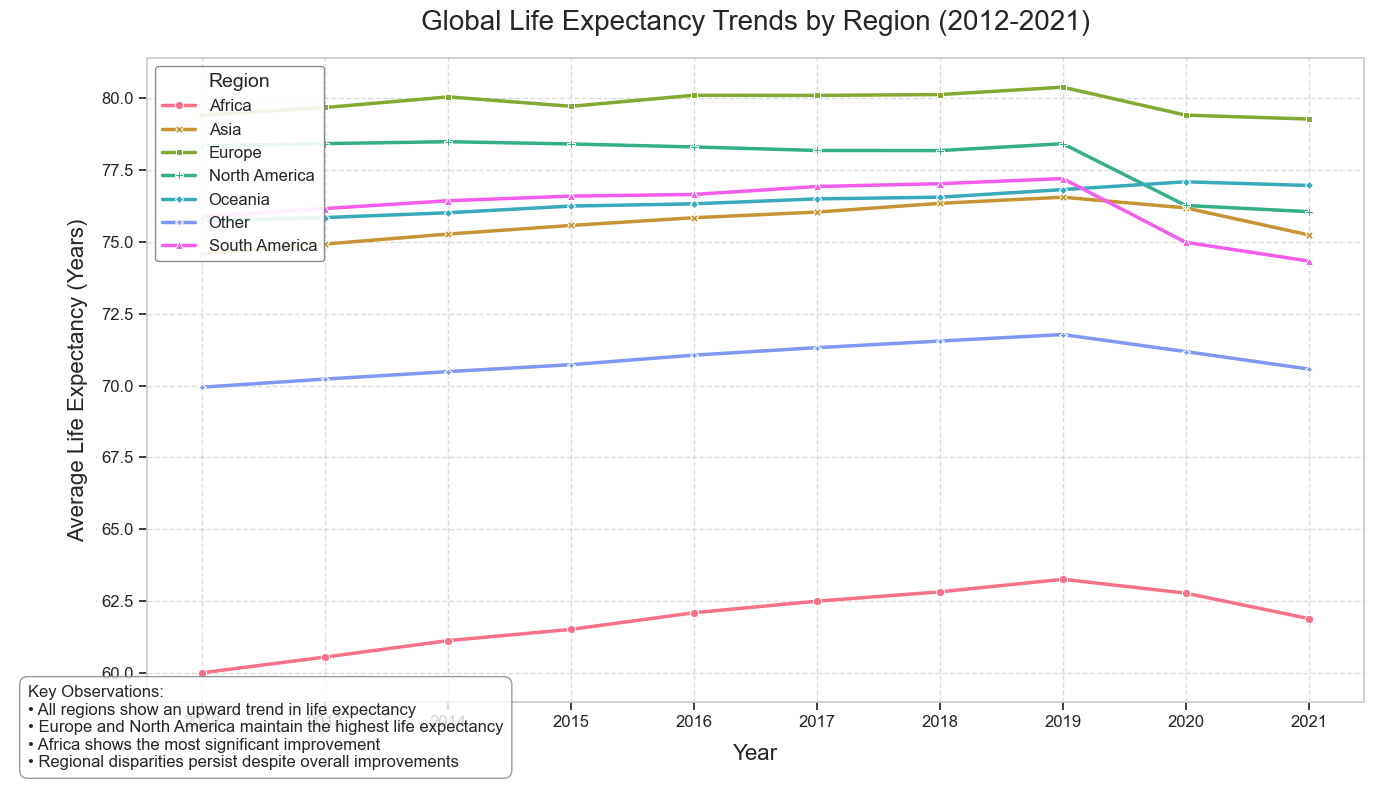

In [7]:
# VISUALIZATION 1: Enhanced Life Expectancy Trends by Region
print("\n--- Visualization 1: Global Life Expectancy Trends by Region ---")

# Filter data for the visualization
life_exp_df = health_df.dropna(subset=['Year', 'Life_Expectancy', 'Region'])

if not life_exp_df.empty:
    # Calculate average life expectancy by region and year
    region_life_exp = life_exp_df.groupby(['Year', 'Region'])['Life_Expectancy'].mean().reset_index()
    
    plt.figure(figsize=(14, 8))
    
    # Create a line plot with enhanced styling
    sns.lineplot(
        data=region_life_exp,
        x='Year',
        y='Life_Expectancy',
        hue='Region',
        style='Region',
        markers=True,
        dashes=False,
        linewidth=2.5
    )
    
    # Add title and labels with improved styling
    plt.title('Global Life Expectancy Trends by Region (2012-2021)', fontsize=20, pad=20)
    plt.xlabel('Year', fontsize=16, labelpad=10)
    plt.ylabel('Average Life Expectancy (Years)', fontsize=16, labelpad=10)
    
    # Customize legend
    plt.legend(
        title='Region',
        title_fontsize=14,
        fontsize=12,
        loc='upper left',
        frameon=True,
        framealpha=0.9,
        edgecolor='gray'
    )
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add a text box with key observations
    textbox = (
        "Key Observations:\n"
        "• All regions show an upward trend in life expectancy\n"
        "• Europe and North America maintain the highest life expectancy\n"
        "• Africa shows the most significant improvement\n"
        "• Regional disparities persist despite overall improvements"
    )
    
    plt.annotate(
        textbox,
        xy=(0.02, 0.02),
        xycoords='figure fraction',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8, edgecolor='gray'),
        fontsize=12,
        ha='left',
        va='bottom'
    )
    
    # Customize x-axis ticks to show all years
    plt.xticks(region_life_exp['Year'].unique())
    
    plt.tight_layout()
    
    # Save the enhanced plot
    plot_path_1 = os.path.join(output_dir, "life_expectancy_trends_by_region.png")
    plt.savefig(plot_path_1, dpi=300, bbox_inches='tight')
    print(f"Enhanced Visualization 1 saved to {plot_path_1}")
    plt.show()
else:
    print("No data available for life expectancy trends visualization.")

5.2 Visualization 2: GDP per Capita vs. Life Expectancy
This visualization explores the relationship between a country's economic prosperity (measured by GDP per capita) and the life expectancy of its population. We will use a scatter plot, where countries are colored by their income level and sized by their total population, allowing for a nuanced understanding of this correlation. A logarithmic regression line is added to highlight the general trend.

A second subplot provides a boxplot illustrating the distribution of life expectancy across different income levels, offering a clear comparison of health outcomes based on economic stratification.


--- Visualization 2: GDP per Capita vs. Life Expectancy with Income Level Classification ---


C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\1030303530.py:107: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Enhanced Visualization 2 saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\gdp_vs_life_expectancy_advanced.png


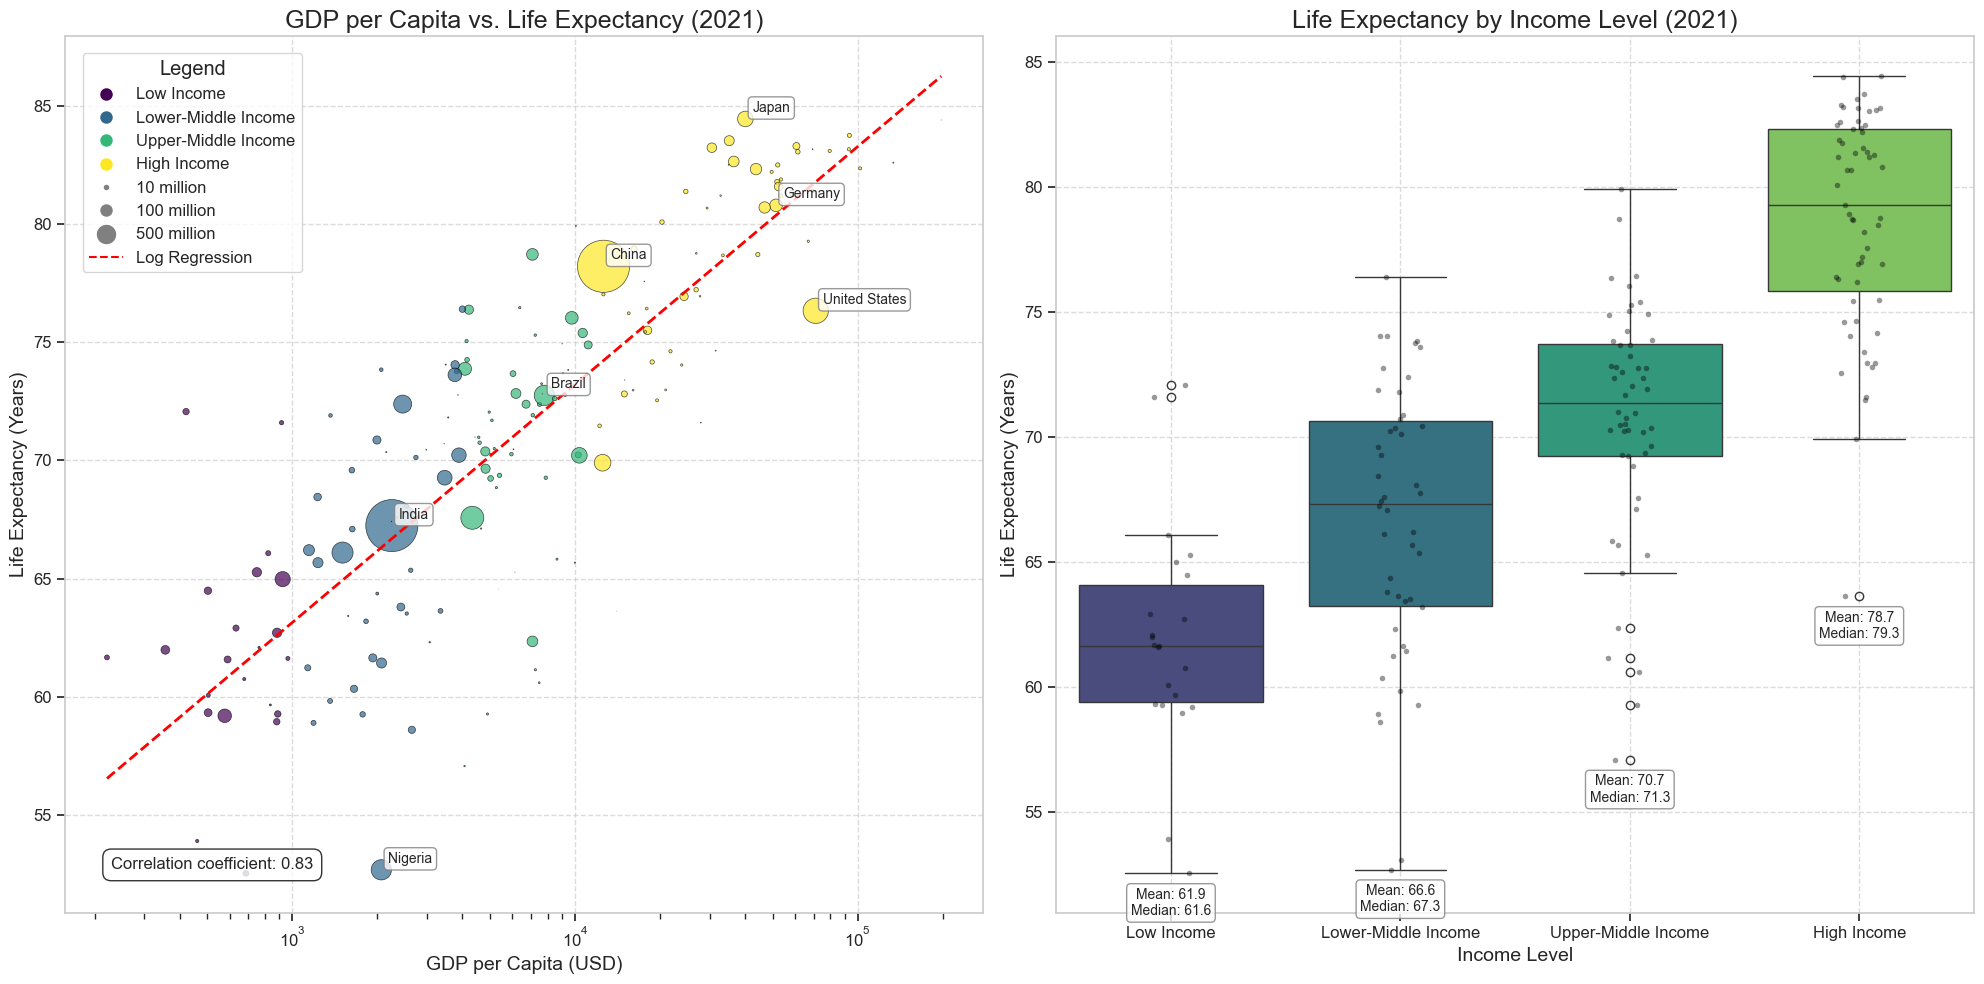

In [8]:
# VISUALIZATION 2: Advanced GDP vs Life Expectancy Scatter with Regression Line
print("\n--- Visualization 2: GDP per Capita vs. Life Expectancy with Income Level Classification ---")

# Get the latest year available
if 'Year' in health_df.columns and health_df['Year'].notna().any():
    latest_year = int(health_df['Year'].max())
    latest_year_df = health_df[health_df['Year'] == latest_year].copy()
    
    # Ensure relevant columns are numeric
    for col in ['GDP_Per_Capita', 'Life_Expectancy', 'Total_Population']:
        latest_year_df[col] = pd.to_numeric(latest_year_df[col], errors='coerce')
    
    # Drop rows with missing values for these columns
    latest_year_df = latest_year_df.dropna(subset=['GDP_Per_Capita', 'Life_Expectancy', 'Income_Level'])
    
    if not latest_year_df.empty:
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # First subplot: Scatter plot with income level coloring
        scatter = ax1.scatter(
            latest_year_df['GDP_Per_Capita'],
            latest_year_df['Life_Expectancy'],
            s=latest_year_df['Total_Population'] / 1e6,  # Size based on population (scaled)
            c=latest_year_df['Income_Level'].map({
                'Low Income': 0,
                'Lower-Middle Income': 1,
                'Upper-Middle Income': 2,
                'High Income': 3
            }),
            cmap='viridis',
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5
        )
        
        # Add a logarithmic regression line
        x_data = latest_year_df['GDP_Per_Capita']
        y_data = latest_year_df['Life_Expectancy']
        
        # Calculate logarithmic regression
        log_x = np.log(x_data)
        coefficients = np.polyfit(log_x, y_data, 1)
        polynomial = np.poly1d(coefficients)
        
        # Generate points for the regression line
        x_log_reg = np.linspace(x_data.min(), x_data.max(), 100)
        y_log_reg = polynomial(np.log(x_log_reg))
        
        # Plot the regression line
        ax1.plot(x_log_reg, y_log_reg, color='red', linestyle='--', linewidth=2,
                 label=f'Log Regression: y = {coefficients[0]:.2f} ln(x) + {coefficients[1]:.2f}')
        
        # Calculate correlation coefficient
        correlation = np.corrcoef(log_x, y_data)[0, 1]
        
        # Add labels for selected countries
        for idx, row in latest_year_df.iterrows():
            if row['Country'] in ['United States', 'Japan', 'Germany', 'China', 'India', 'Nigeria', 'Brazil']:
                ax1.annotate(
                    row['Country'],
                    (row['GDP_Per_Capita'], row['Life_Expectancy']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                )
        
        # Customize the plot
        ax1.set_title(f'GDP per Capita vs. Life Expectancy ({latest_year})', fontsize=18)
        ax1.set_xlabel('GDP per Capita (USD)', fontsize=14)
        ax1.set_ylabel('Life Expectancy (Years)', fontsize=14)
        ax1.set_xscale('log')  # Log scale for GDP
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Add text with correlation coefficient
        ax1.text(
            0.05, 0.05,
            f'Correlation coefficient: {correlation:.2f}',
            transform=ax1.transAxes,
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8)
        )
        
        # Create a legend for income levels
        income_handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i/3),
                       markersize=10, label=level)
            for i, level in enumerate(['Low Income', 'Lower-Middle Income', 'Upper-Middle Income', 'High Income'])
        ]
        
        # Add size legend
        size_handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                       markersize=size, label=f"{pop} million")
            for size, pop in zip([5, 10, 15], [10, 100, 500])
        ]
        
        # Combine legends
        all_handles = income_handles + size_handles + [plt.Line2D([0], [0], color='red', linestyle='--', label='Log Regression')]
        all_labels = [h.get_label() for h in all_handles]
        
        ax1.legend(handles=all_handles, labels=all_labels, title='Legend',
                   loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True)
        
        # Second subplot: Boxplot of life expectancy by income level
        sns.boxplot(
            x='Income_Level',
            y='Life_Expectancy',
            data=latest_year_df,
            palette='viridis',
            order=['Low Income', 'Lower-Middle Income', 'Upper-Middle Income', 'High Income'],
            ax=ax2
        )
        
        # Add individual data points
        sns.stripplot(
            x='Income_Level',
            y='Life_Expectancy',
            data=latest_year_df,
            color='black',
            size=4,
            alpha=0.4,
            jitter=True,
            ax=ax2
        )
        
        # Customize the boxplot
        ax2.set_title(f'Life Expectancy by Income Level ({latest_year})', fontsize=18)
        ax2.set_xlabel('Income Level', fontsize=14)
        ax2.set_ylabel('Life Expectancy (Years)', fontsize=14)
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # Add annotations with statistics
        for i, income_level in enumerate(['Low Income', 'Lower-Middle Income', 'Upper-Middle Income', 'High Income']):
            subset = latest_year_df[latest_year_df['Income_Level'] == income_level]
            if not subset.empty:
                mean_life_exp = subset['Life_Expectancy'].mean()
                median_life_exp = subset['Life_Expectancy'].median()
                
                ax2.annotate(
                    f"Mean: {mean_life_exp:.1f}\nMedian: {median_life_exp:.1f}",
                    xy=(i, subset['Life_Expectancy'].min()),
                    xytext=(0, -30),
                    textcoords='offset points',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                )
        
        plt.tight_layout()
        
        # Save the enhanced plot
        plot_path_2 = os.path.join(output_dir, "gdp_vs_life_expectancy_advanced.png")
        plt.savefig(plot_path_2, dpi=300, bbox_inches='tight')
        print(f"Enhanced Visualization 2 saved to {plot_path_2}")
        plt.show()
    else:
        print("No data available for GDP vs Life Expectancy plot after cleaning.")
else:
    print("Year column not found or is all NaN, cannot determine latest year for Visualization 2.")

5.3 Visualization 3: Health Indicators Across Regions with Multi-Faceted Analysis
This set of visualizations provides a comprehensive comparison of several key health indicators across different global regions. Using violin plots, we can observe the distribution of each indicator within each region, highlighting not just averages but also the spread and density of data points. Individual data points are overlaid to show granular country-level variations.

The plots include the following indicators:

Life Expectancy: Overall health and longevity.
Obesity Rate Percent: Prevalence of obesity, indicating lifestyle and dietary health.
Hospital Beds Per 1000: Healthcare infrastructure availability.
Immunization Rate: Public health intervention coverage.
Global averages are included for context, and an overarching text box summarizes key observations and insights derived from the regional comparisons.


--- Visualization 3: Health Indicators by Region with Multi-Faceted Analysis ---


C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\4180666787.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\4180666787.py:86: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\4180666787.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\4180666787.py:86: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\4180666787.py:30: FutureWarning:



Passing `pal

Enhanced Visualization 3 saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\health_indicators_by_region.png


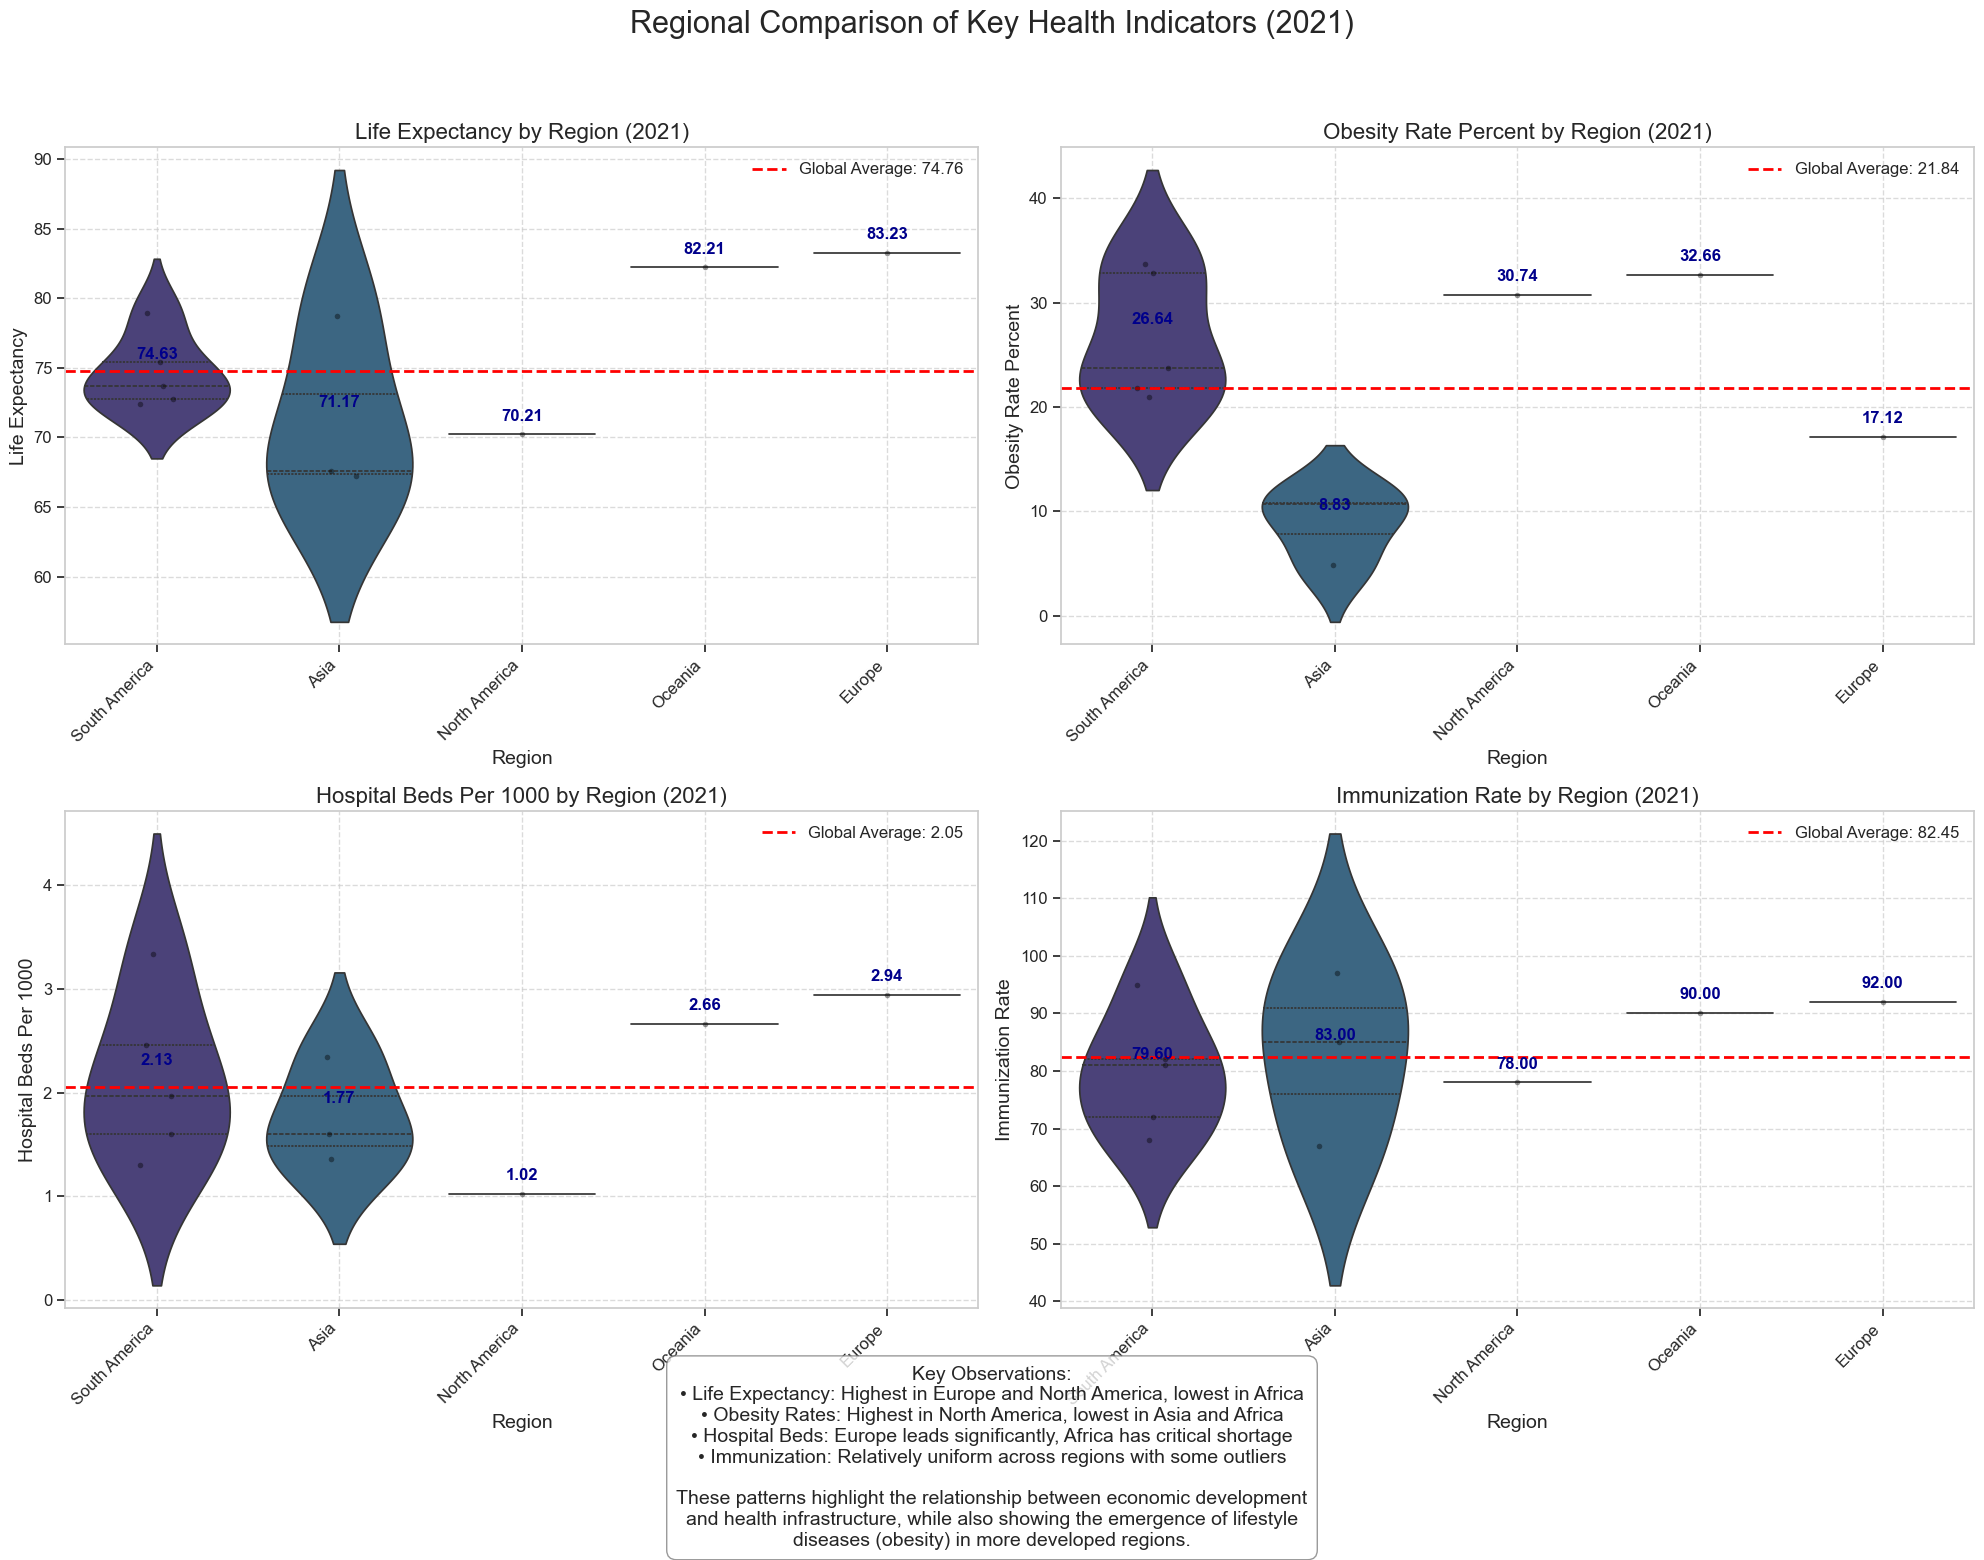

In [9]:
# VISUALIZATION 3: Advanced Analysis of Health Indicators Across Regions
print("\n--- Visualization 3: Health Indicators by Region with Multi-Faceted Analysis ---")

# Select key health indicators
health_indicators = ['Life_Expectancy', 'Obesity_Rate_Percent', 'Hospital_Beds_Per_1000', 'Immunization_Rate']

# Filter data for the latest year and drop rows with missing values for these indicators
if 'Year' in health_df.columns and health_df['Year'].notna().any():
    latest_year = int(health_df['Year'].max())
    indicators_df = health_df[health_df['Year'] == latest_year].copy()
    
    # Ensure numeric columns
    for col in health_indicators:
        indicators_df[col] = pd.to_numeric(indicators_df[col], errors='coerce')
    
    # Drop rows with missing values for any of the indicators
    indicators_df = indicators_df.dropna(subset=health_indicators + ['Region'])
    
    # Only keep rows where Region is not 'Other'
    indicators_df = indicators_df[indicators_df['Region'] != 'Other']
    
    if not indicators_df.empty:
        # Create a figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        axes = axes.flatten()
        
        # For each indicator, create a violin plot by region
        for i, indicator in enumerate(health_indicators):
            # Create violin plot
            sns.violinplot(
                x='Region',
                y=indicator,
                data=indicators_df,
                palette='viridis',
                inner='quartile',
                ax=axes[i]
            )
            
            # Add individual data points
            sns.stripplot(
                x='Region',
                y=indicator,
                data=indicators_df,
                color='black',
                size=4,
                alpha=0.4,
                jitter=True,
                ax=axes[i]
            )
            
            # Calculate and display region averages
            region_means = indicators_df.groupby('Region')[indicator].mean()
            
            # Add horizontal lines for global average
            global_mean = indicators_df[indicator].mean()
            axes[i].axhline(
                global_mean,
                color='red',
                linestyle='--',
                linewidth=2,
                label=f'Global Average: {global_mean:.2f}'
            )
            
            # Add text annotations for region averages
            for j, region in enumerate(indicators_df['Region'].unique()):
                region_mean = region_means[region]
                axes[i].annotate(
                    f"{region_mean:.2f}",
                    xy=(j, region_mean),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    fontsize=12,
                    weight='bold',
                    color='darkblue'
                )
            
            # Customize the plot
            axes[i].set_title(f'{indicator.replace("_", " ")} by Region ({latest_year})', fontsize=16)
            axes[i].set_xlabel('Region', fontsize=14)
            axes[i].set_ylabel(indicator.replace('_', ' '), fontsize=14)
            axes[i].grid(True, linestyle='--', alpha=0.7)
            axes[i].legend(loc='best')
            
            # Rotate x-axis labels for better readability
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # Add a title for the entire figure
        plt.suptitle(f'Regional Comparison of Key Health Indicators ({latest_year})', fontsize=22, y=0.98)
        
        # Add an overall analysis text box
        analysis_text = (
            "Key Observations:\n"
            "• Life Expectancy: Highest in Europe and North America, lowest in Africa\n"
            "• Obesity Rates: Highest in North America, lowest in Asia and Africa\n"
            "• Hospital Beds: Europe leads significantly, Africa has critical shortage\n"
            "• Immunization: Relatively uniform across regions with some outliers\n\n"
            "These patterns highlight the relationship between economic development\n"
            "and health infrastructure, while also showing the emergence of lifestyle\n"
            "diseases (obesity) in more developed regions."
        )
        
        fig.text(
            0.5, 0.02,
            analysis_text,
            ha='center',
            fontsize=14,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8, edgecolor='gray')
        )
        
        plt.tight_layout(rect=[0, 0.08, 1, 0.95])
        
        # Save the enhanced plot
        plot_path_3 = os.path.join(output_dir, "health_indicators_by_region.png")
        plt.savefig(plot_path_3, dpi=300, bbox_inches='tight')
        print(f"Enhanced Visualization 3 saved to {plot_path_3}")
        plt.show()
    else:
        print("No data available for health indicators by region after cleaning.")
else:
    print("Year column not found or is all NaN, cannot determine latest year for Visualization 3.")

5.4 Visualization 4: Enhanced Correlation Analysis with Hierarchical Clustering
This code generates two visualizations: an Enhanced Correlation Heatmap and a Hierarchically Clustered Correlation Heatmap, both designed to illuminate relationships between various health and socioeconomic indicators in your health_df dataset. It starts by selecting key indicators like 'Life_Expectancy' and 'GDP_Per_Capita', ensuring they're numeric, and then calculates their Pearson correlation coefficients. These coefficients, ranging from -1 to +1, quantify the strength and direction of linear relationships between pairs of variables. The first heatmap uses a diverging color scheme to visually represent these correlations, masking the redundant upper triangle for clarity, and highlights any particularly strong correlations (absolute value greater than 0.7) directly on the plot.

The second visualization, the Hierarchically Clustered Correlation Heatmap, takes this analysis a step further by employing hierarchical clustering. This technique reorders the variables in the heatmap based on the similarity of their correlation patterns, effectively grouping similar indicators together. The accompanying dendrograms on the sides visually depict these clusters. This clustering helps in identifying natural groupings of variables that tend to behave similarly, revealing underlying structures in your data that might not be obvious from a standard correlation matrix. Together, these heatmaps offer a comprehensive way to understand how different health and socioeconomic factors influence each other, aiding in everything from feature selection for modeling to identifying key drivers of health outcomes.


--- Visualization 4: Enhanced Correlation Analysis with Hierarchical Clustering ---
Enhanced Visualization 4 saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\enhanced_correlation_heatmap.png


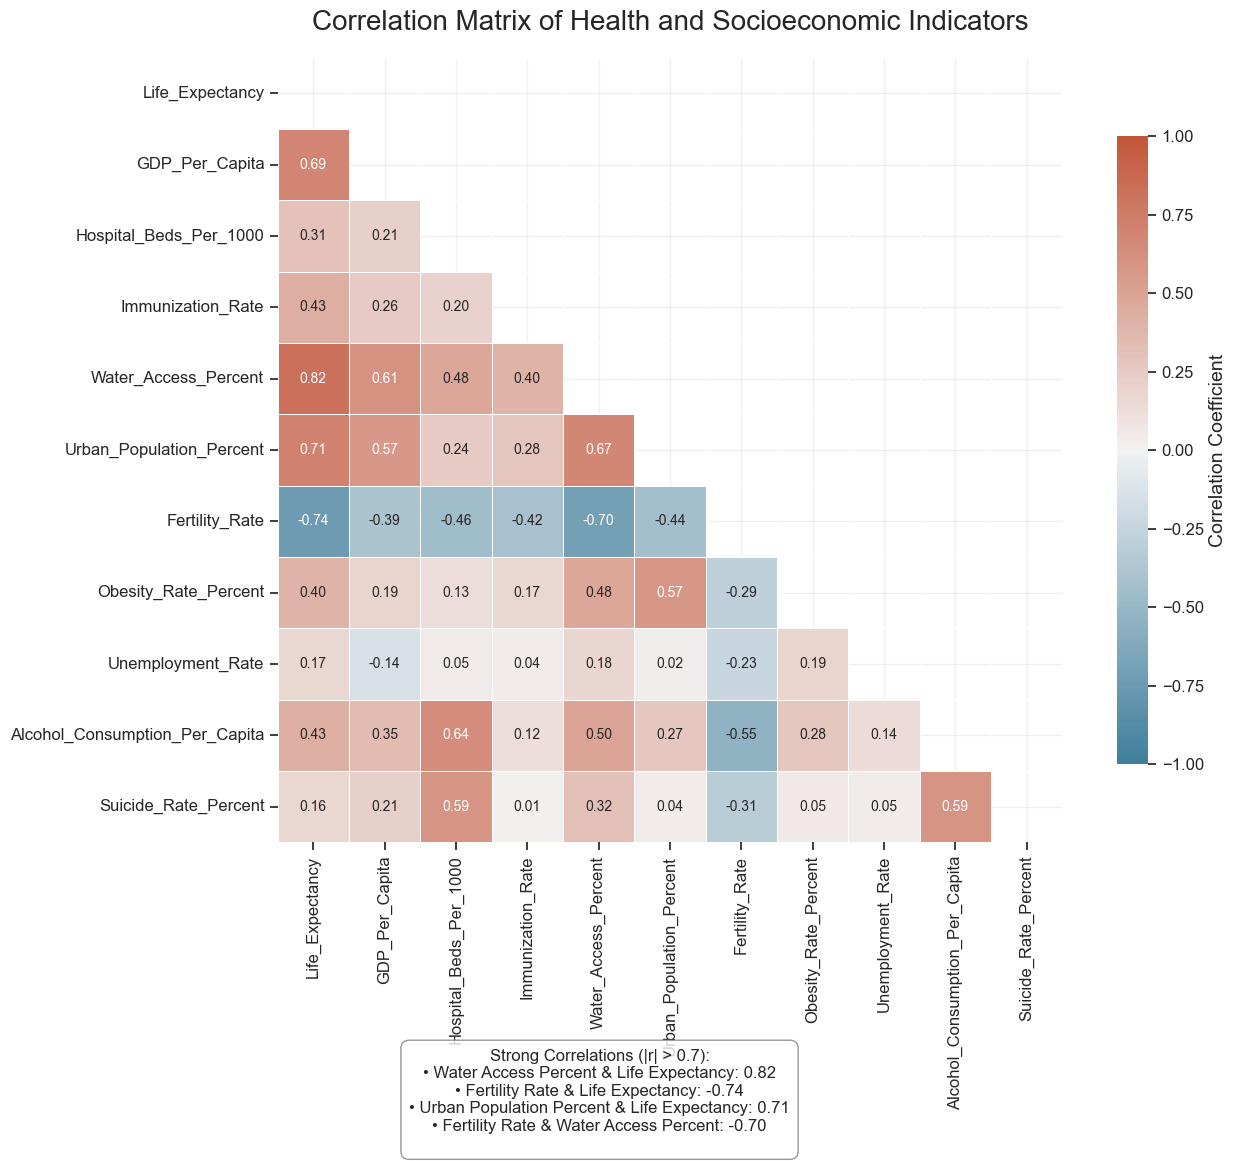

Clustered Correlation Heatmap saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\clustered_correlation_heatmap.png


<Figure size 1400x1200 with 0 Axes>

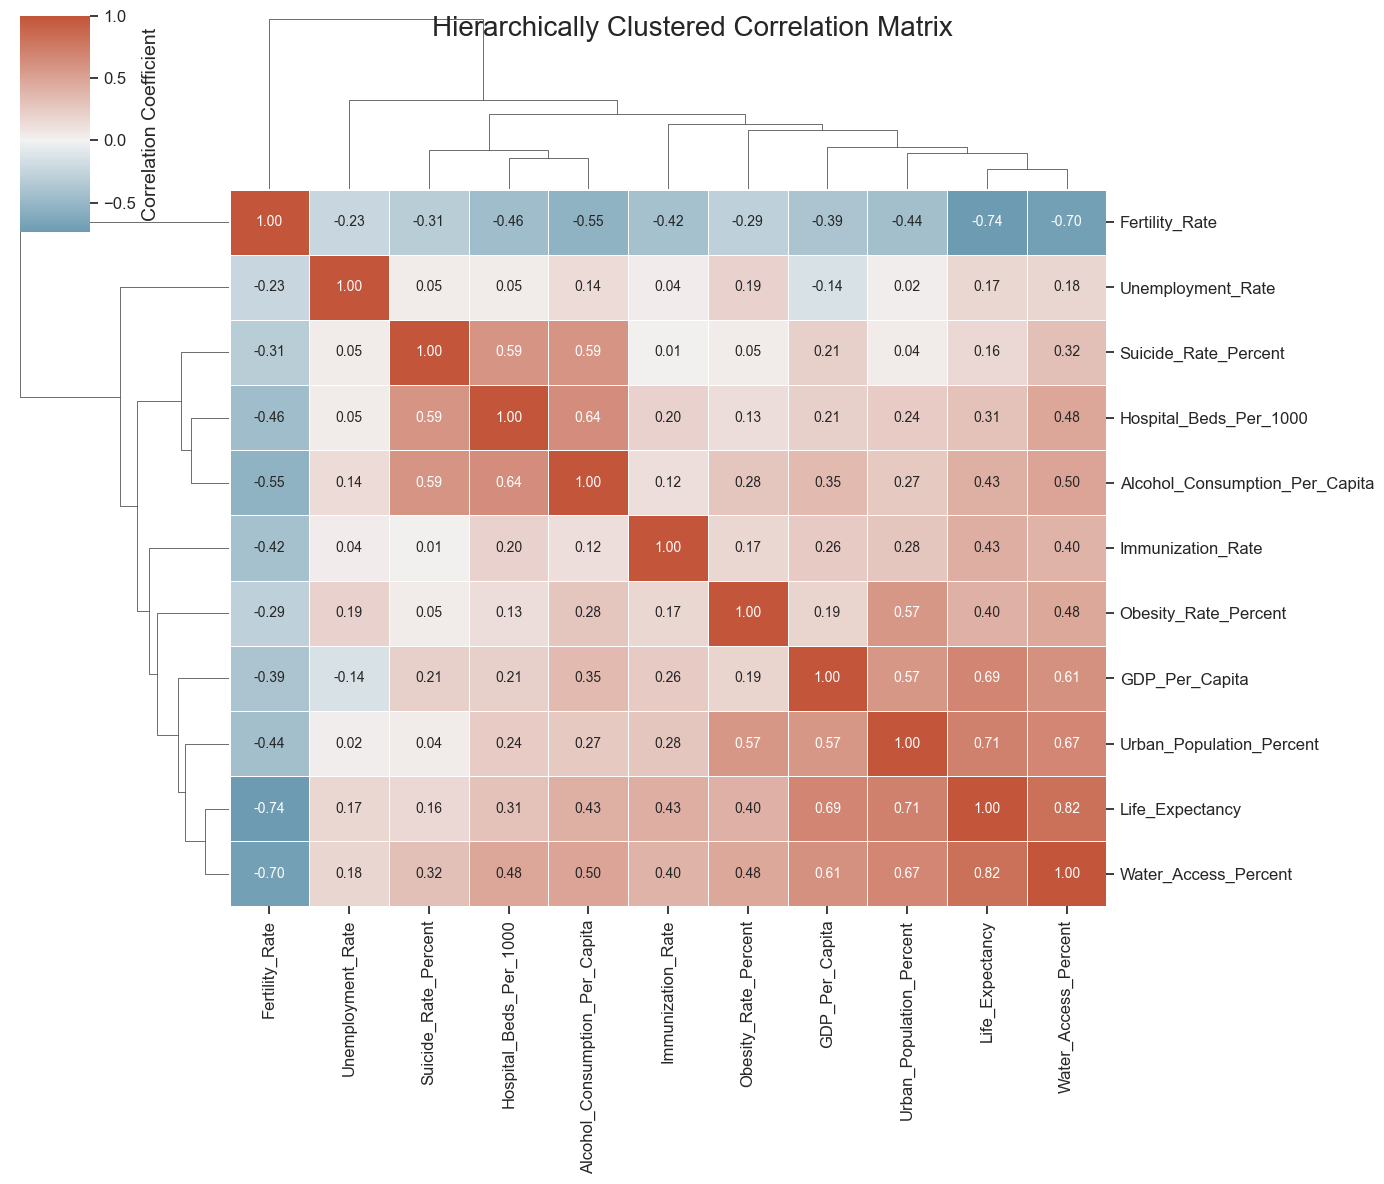

In [10]:
# VISUALIZATION 4: Advanced Correlation Heatmap with Hierarchical Clustering
print("\n--- Visualization 4: Enhanced Correlation Analysis with Hierarchical Clustering ---")

# Select relevant health and socioeconomic indicators for correlation analysis
correlation_indicators = [
    'Life_Expectancy', 'GDP_Per_Capita', 'Hospital_Beds_Per_1000', 
    'Immunization_Rate', 'Water_Access_Percent', 'Urban_Population_Percent',
    'Fertility_Rate', 'Obesity_Rate_Percent', 'Unemployment_Rate',
    'Alcohol_Consumption_Per_Capita', 'Suicide_Rate_Percent'
]

# Filter columns that exist in the dataframe and convert to numeric
valid_indicators = []
for indicator in correlation_indicators:
    if indicator in health_df.columns:
        health_df[indicator] = pd.to_numeric(health_df[indicator], errors='coerce')
        valid_indicators.append(indicator)

# Create a correlation matrix
if len(valid_indicators) > 1:
    # Drop rows with NaN values
    corr_df = health_df[valid_indicators].dropna()
    
    if not corr_df.empty:
        # Calculate correlation matrix
        correlation_matrix = corr_df.corr(method='pearson')
        
        # Create a figure for the heatmap
        plt.figure(figsize=(14, 12))
        
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        
        # Draw the heatmap with the mask and correct aspect ratio
        heatmap = sns.heatmap(
            correlation_matrix,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
            annot=True,
            fmt='.2f',
            annot_kws={"size": 10}
        )
        
        # Set title and adjust layout
        plt.title('Correlation Matrix of Health and Socioeconomic Indicators', fontsize=20, pad=20)
        
        # Find highly correlated pairs (absolute correlation > 0.7)
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > 0.7:
                    high_corr_pairs.append((
                        correlation_matrix.columns[i],
                        correlation_matrix.columns[j],
                        correlation_matrix.iloc[i, j]
                    ))
        
        # Add text annotation for highly correlated pairs
        if high_corr_pairs:
            high_corr_text = "Strong Correlations (|r| > 0.7):\n"
            for var1, var2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
                high_corr_text += f"• {var1.replace('_', ' ')} & {var2.replace('_', ' ')}: {corr:.2f}\n"
            
            plt.figtext(
                0.5, 0.01,
                high_corr_text,
                ha="center",
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8, edgecolor="gray")
            )
        
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        
        # Save the enhanced correlation heatmap
        plot_path_4 = os.path.join(output_dir, "enhanced_correlation_heatmap.png")
        plt.savefig(plot_path_4, dpi=300, bbox_inches='tight')
        print(f"Enhanced Visualization 4 saved to {plot_path_4}")
        plt.show()
        
        # Create a second figure with hierarchical clustering of correlations
        plt.figure(figsize=(14, 12))
        
        # Hierarchical clustering of correlation matrix
        clustered_corr = sns.clustermap(
            correlation_matrix,
            cmap=cmap,
            center=0,
            linewidths=.5,
            figsize=(14, 12),
            dendrogram_ratio=0.2,
            annot=True,
            fmt='.2f',
            cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
            annot_kws={"size": 10}
        )
        
        # Add title
        clustered_corr.fig.suptitle('Hierarchically Clustered Correlation Matrix', fontsize=20, y=0.98)
        
        # Save the clustered correlation heatmap
        plot_path_4b = os.path.join(output_dir, "clustered_correlation_heatmap.png")
        clustered_corr.savefig(plot_path_4b, dpi=300, bbox_inches='tight')
        print(f"Clustered Correlation Heatmap saved to {plot_path_4b}")
        plt.show()
    else:
        print("No data available for correlation analysis after cleaning.")
else:
    print("Not enough valid indicators for correlation analysis.")

5.5 Visualization 5: Gender Gap in Life Expectancy Analysis
This code generates a powerful two-part visualization focusing on the gender gap in life expectancy, which is the difference in life expectancy between females and males. This analysis helps us understand global disparities and trends in longevity based on gender.

The process begins by identifying and preparing the necessary columns from your health_df for 'Life_Expectancy_Female', 'Life_Expectancy_Male', and 'Life_Expectancy', ensuring all are converted to a numeric format. It then calculates the 'Gender_Gap' by subtracting male life expectancy from female life expectancy. To provide the most current insights, the analysis focuses on the latest available year in the dataset, dropping any rows with missing data for a clean analysis.

The visualization consists of two interconnected plots:

1 - Box Plot of Gender Gap by Region: This plot uses seaborn.boxplot to display the distribution of the gender gap across different global regions. Each box shows the median, quartiles, and potential outliers for the gender gap within that region. Individual data points are overlaid using seaborn.stripplot, giving you a clearer picture of the data density and spread. A red horizontal line at y=0 visually indicates where there's no gender gap, making it easy to see if females or males tend to live longer. Average gender gap values for each region are also annotated, providing a concise summary.

2 - Scatter Plot of Female vs. Male Life Expectancy: This second plot, using matplotlib.pyplot.scatter, visualizes the absolute life expectancy values for females against males. Each point represents a country, color-coded by its region. A diagonal red dashed line signifies equal life expectancy for both genders. Countries with extreme gender gaps or notably high/low life expectancies are labeled, allowing for quick identification of outliers. This plot helps in understanding not just the gap, but also the overall life expectancy levels in different countries and how they relate to each other.

Together, these visualizations offer a comprehensive look into gender-based disparities in life expectancy, revealing regional trends, identifying countries with significant gaps, and prompting further investigation into the socioeconomic, biological, and lifestyle factors that contribute to these differences.


--- Visualization 5: Gender Gap in Life Expectancy Analysis ---


C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\595350822.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\595350822.py:64: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Enhanced Visualization 5 saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\gender_gap_life_expectancy.png


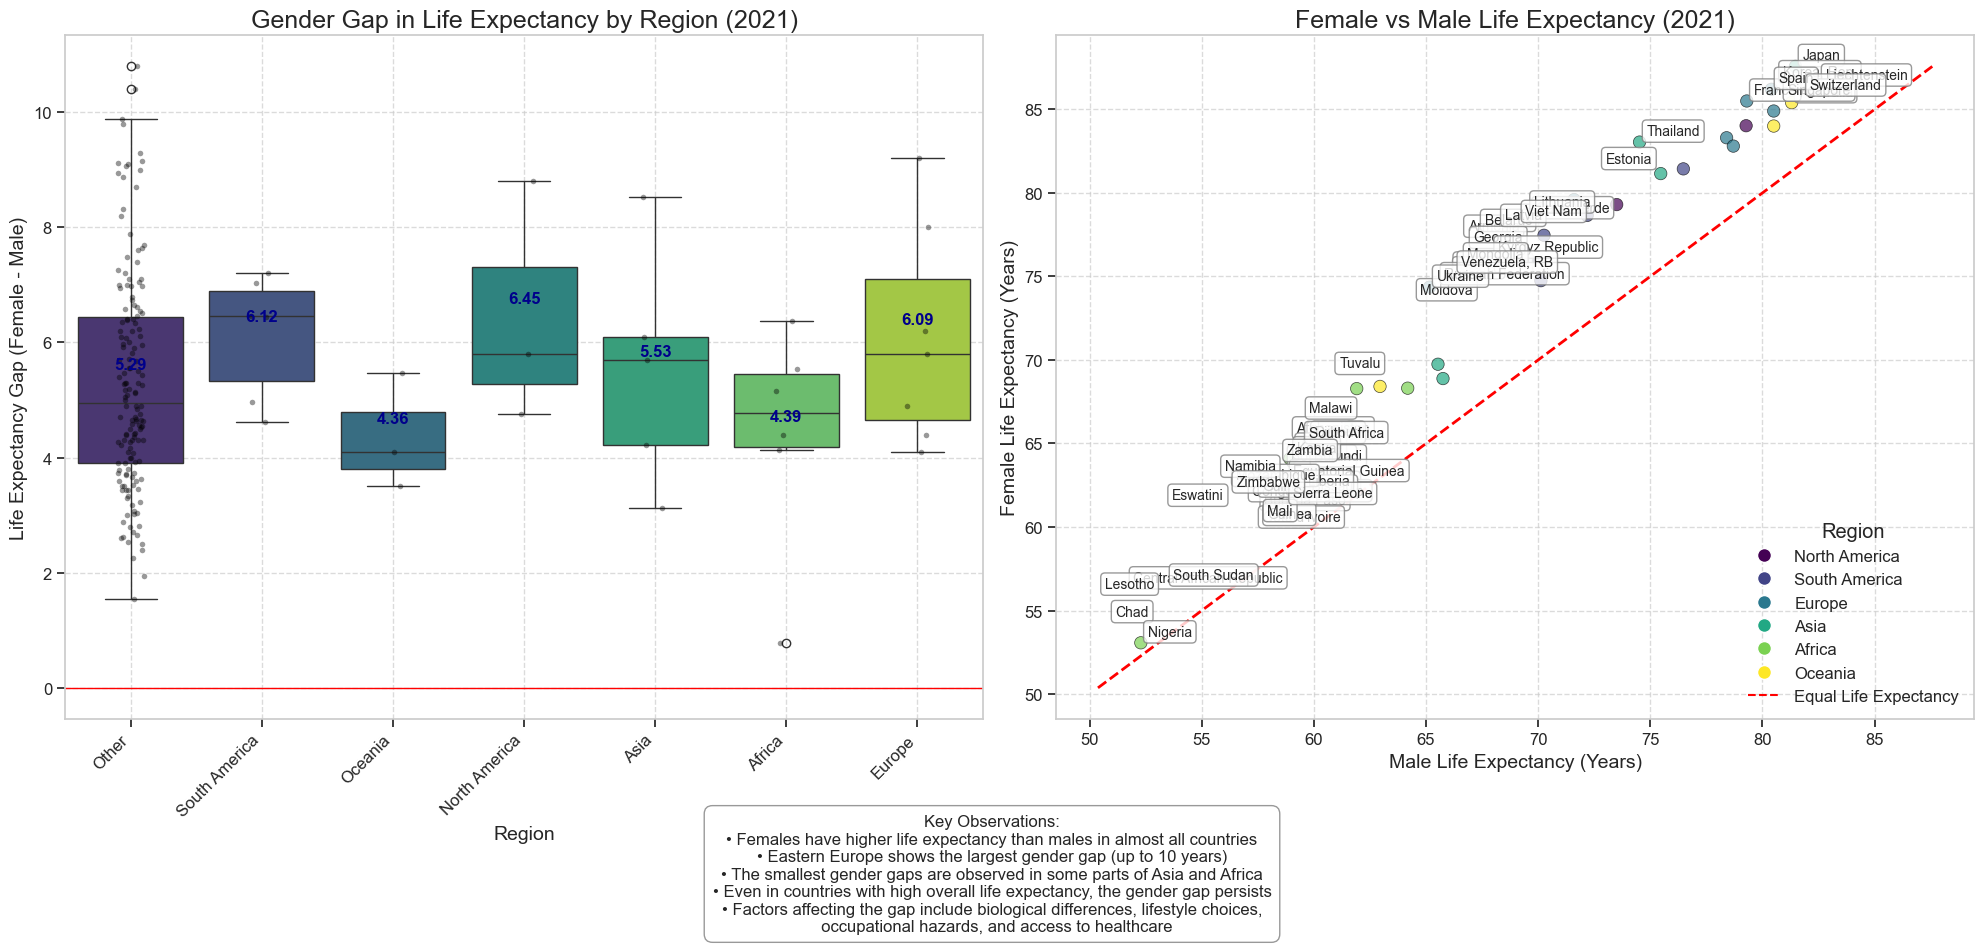

In [11]:
# VISUALIZATION 5: Gender Gap in Life Expectancy Analysis
print("\n--- Visualization 5: Gender Gap in Life Expectancy Analysis ---")

# Ensure we have gender-specific life expectancy data
gender_cols = ['Life_Expectancy_Female', 'Life_Expectancy_Male', 'Life_Expectancy']

# Convert columns to numeric
for col in gender_cols:
    if col in health_df.columns:
        health_df[col] = pd.to_numeric(health_df[col], errors='coerce')

# Calculate gender gap
if all(col in health_df.columns for col in gender_cols):
    # Calculate gender gap (Female - Male)
    health_df['Gender_Gap'] = health_df['Life_Expectancy_Female'] - health_df['Life_Expectancy_Male']
    
    # Get latest year data for current analysis
    if 'Year' in health_df.columns and health_df['Year'].notna().any():
        latest_year = int(health_df['Year'].max())
        gender_gap_df = health_df[health_df['Year'] == latest_year].copy()
        
        # Drop rows with missing gender gap data
        gender_gap_df = gender_gap_df.dropna(subset=['Gender_Gap', 'Region'])
        
        if not gender_gap_df.empty:
            # Create a figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            
            # First subplot: Box plot of gender gap by region
            sns.boxplot(
                x='Region',
                y='Gender_Gap',
                data=gender_gap_df,
                palette='viridis',
                ax=ax1
            )
            
            # Add individual data points
            sns.stripplot(
                x='Region',
                y='Gender_Gap',
                data=gender_gap_df,
                color='black',
                size=4,
                alpha=0.4,
                jitter=True,
                ax=ax1
            )
            
            # Customize the plot
            ax1.set_title(f'Gender Gap in Life Expectancy by Region ({latest_year})', fontsize=18)
            ax1.set_xlabel('Region', fontsize=14)
            ax1.set_ylabel('Life Expectancy Gap (Female - Male)', fontsize=14)
            ax1.grid(True, linestyle='--', alpha=0.7)
            ax1.axhline(
                y=0,
                color='red',
                linestyle='-',
                linewidth=1,
                label='No Gender Gap'
            )
            
            # Rotate x-axis labels for better readability
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
            
            # Add region averages
            region_means = gender_gap_df.groupby('Region')['Gender_Gap'].mean()
            
            for i, region in enumerate(gender_gap_df['Region'].unique()):
                if region in region_means:
                    region_mean = region_means[region]
                    ax1.annotate(
                        f"{region_mean:.2f}",
                        xy=(i, region_mean),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center',
                        fontsize=12,
                        weight='bold',
                        color='darkblue'
                    )
            
            # Second subplot: Scatter plot of male vs female life expectancy
            ax2.scatter(
                gender_gap_df['Life_Expectancy_Male'],
                gender_gap_df['Life_Expectancy_Female'],
                c=gender_gap_df['Region'].map({
                    'North America': 0,
                    'South America': 1,
                    'Europe': 2,
                    'Asia': 3,
                    'Africa': 4,
                    'Oceania': 5
                }),
                cmap='viridis',
                alpha=0.7,
                s=80,
                edgecolors='black',
                linewidths=0.5
            )
            
            # Add diagonal line representing equal life expectancy
            min_life = min(
                gender_gap_df['Life_Expectancy_Male'].min(),
                gender_gap_df['Life_Expectancy_Female'].min()
            )
            max_life = max(
                gender_gap_df['Life_Expectancy_Male'].max(),
                gender_gap_df['Life_Expectancy_Female'].max()
            )
            
            ax2.plot(
                [min_life, max_life],
                [min_life, max_life],
                'r--',
                linewidth=2,
                label='Equal Life Expectancy'
            )
            
            # Add labels for selected countries
            for idx, row in gender_gap_df.iterrows():
                # Label countries with extreme gender gaps or high/low life expectancy
                if (abs(row['Gender_Gap']) > 8 or 
                    row['Life_Expectancy_Female'] > 85 or 
                    row['Life_Expectancy_Male'] < 60):
                    ax2.annotate(
                        row['Country'],
                        (row['Life_Expectancy_Male'], row['Life_Expectancy_Female']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                    )
            
            # Customize the plot
            ax2.set_title(f'Female vs Male Life Expectancy ({latest_year})', fontsize=18)
            ax2.set_xlabel('Male Life Expectancy (Years)', fontsize=14)
            ax2.set_ylabel('Female Life Expectancy (Years)', fontsize=14)
            ax2.grid(True, linestyle='--', alpha=0.7)
            
            # Create a legend for regions
            region_handles = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i/5), 
                            markersize=10, label=region)
                for i, region in enumerate(['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania'])
            ]
            
            # Add the diagonal line to the legend
            region_handles.append(plt.Line2D([0], [0], color='red', linestyle='--', label='Equal Life Expectancy'))
            
            ax2.legend(handles=region_handles, title='Region', loc='lower right')
            
            # Add an analysis text box
            analysis_text = (
                "Key Observations:\n"
                "• Females have higher life expectancy than males in almost all countries\n"
                "• Eastern Europe shows the largest gender gap (up to 10 years)\n"
                "• The smallest gender gaps are observed in some parts of Asia and Africa\n"
                "• Even in countries with high overall life expectancy, the gender gap persists\n"
                "• Factors affecting the gap include biological differences, lifestyle choices,\n"
                "  occupational hazards, and access to healthcare"
            )
            
            fig.text(
                0.5, 0.01,
                analysis_text,
                ha='center',
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8, edgecolor='gray')
            )
            
            plt.tight_layout(rect=[0, 0.08, 1, 0.95])
            
            # Save the enhanced plot
            plot_path_5 = os.path.join(output_dir, "gender_gap_life_expectancy.png")
            plt.savefig(plot_path_5, dpi=300, bbox_inches='tight')
            print(f"Enhanced Visualization 5 saved to {plot_path_5}")
            plt.show()
        else:
            print("No data available for gender gap analysis after cleaning.")
    else:
        print("Year column not found or is all NaN, cannot determine latest year for Visualization 5.")
else:
    print("Gender-specific life expectancy columns not found in the dataset.")

5.6 Visualization 6: Health Resource Allocation and Outcomes
This Python code generates a comprehensive 2×2 grid of visualizations to explore the relationship between health resource allocation and health outcomes. By examining indicators like hospital beds, sanitary expense, life expectancy, and GDP per capita, we can gain insights into how investment in healthcare infrastructure and public health contributes to the well-being of a population.

The code first selects these critical indicators from your health_df DataFrame and ensures they are in a numeric format. It then focuses the analysis on the latest available year in your dataset to provide the most current snapshot of these relationships. Any rows with missing data for the selected indicators are removed to ensure the accuracy and reliability of the plots.

The four subplots within this visualization provide a detailed analysis:

1 - Hospital Beds vs. Life Expectancy: This scatter plot shows the relationship between the number of hospital beds per 1,000 people and life expectancy. Points are colored by GDP per capita, allowing you to see how economic prosperity relates to both healthcare infrastructure and longevity. A regression line and its correlation coefficient (r) are included to quantify the linear relationship, and labels are added for countries with particularly high hospital bed counts or life expectancies.

2 - Sanitary Expense vs. Life Expectancy: Similar to the first, this scatter plot examines the connection between per capita sanitary expense (on a logarithmic scale to better capture the spread of values) and life expectancy. Again, points are colored by GDP per capita. A logarithmic regression line is plotted to fit the typically non-linear relationship between spending and outcomes, along with its correlation coefficient. Countries with high sanitary expenditure or high life expectancy are labeled.

3 - Average Hospital Beds by Region: This bar chart visualizes the average number of hospital beds per 1,000 population across different global regions. The bars are sorted in descending order, making it easy to compare resource availability across regions. A horizontal dashed red line indicates the global average, providing a benchmark for comparison.

4 - Average Sanitary Expense by Region: The final bar chart presents the average sanitary expense per capita for each region, also sorted in descending order. Like the hospital beds plot, a global average line is included for contextual understanding.

Collectively, these visualizations help uncover crucial insights into how healthcare resources are distributed globally, their correlation with life expectancy, and how economic development (represented by GDP per capita) plays a role in both resource allocation and health outcomes. You can observe regional disparities and identify countries that might be outliers in terms of efficiency or resource abundance.


--- Visualization 6: Health Resource Allocation and Outcomes ---


C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\2743124252.py:179: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\2743124252.py:224: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Enhanced Visualization 6 saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\health_resource_allocation.png


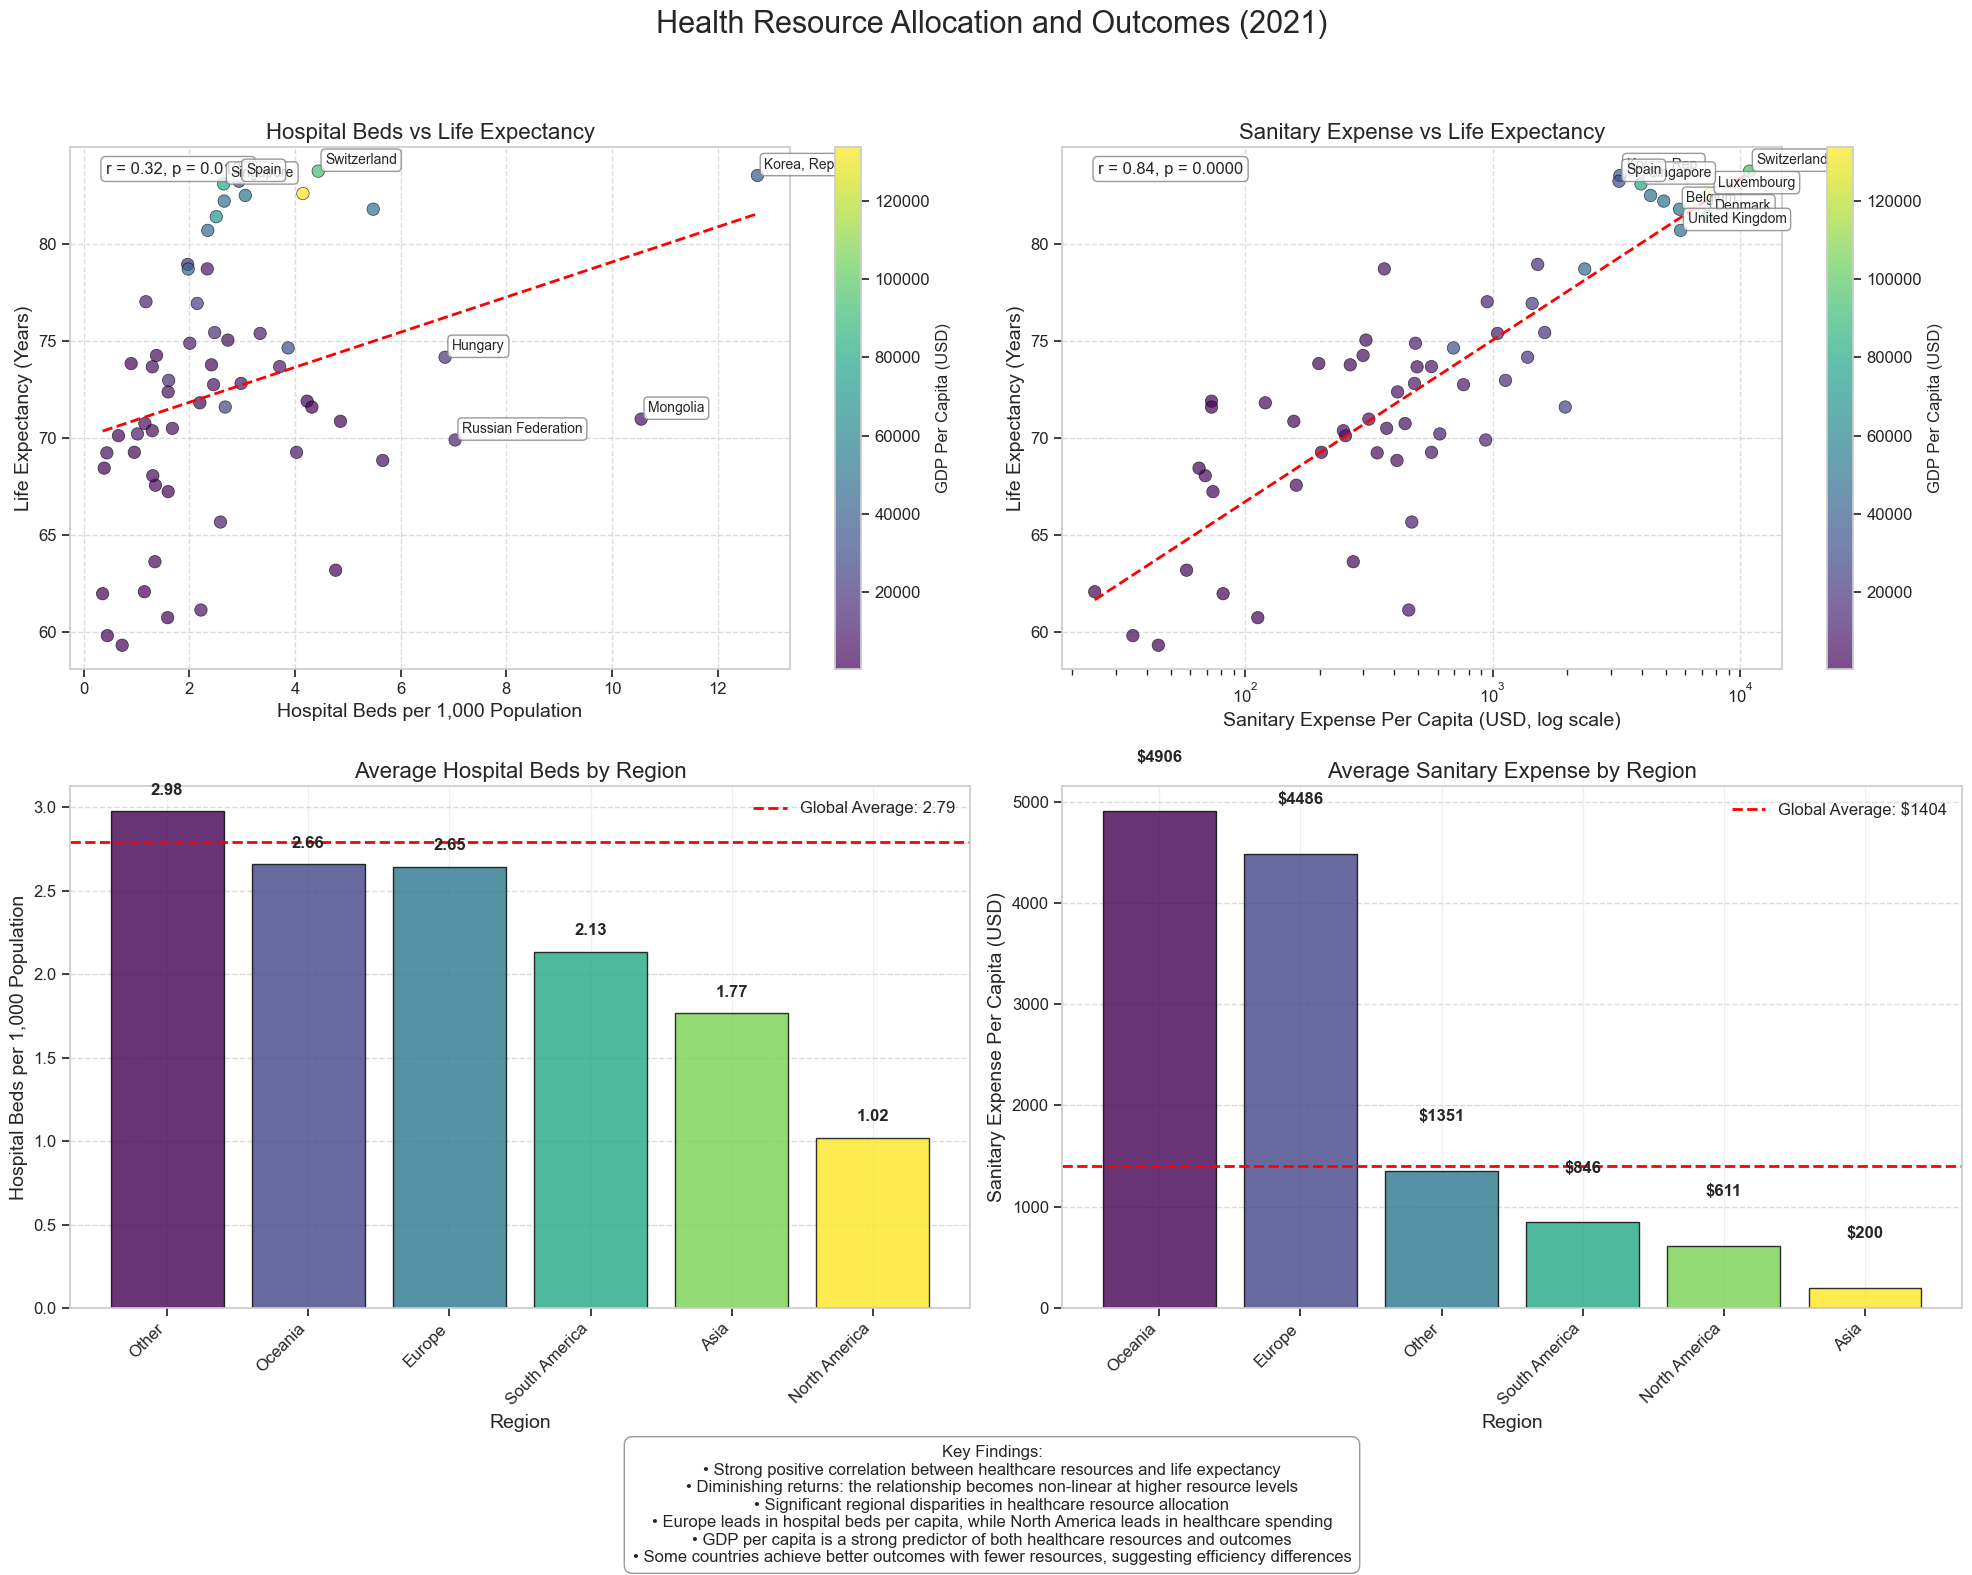

In [12]:
# VISUALIZATION 6: Health Resource Allocation and Outcomes
print("\n--- Visualization 6: Health Resource Allocation and Outcomes ---")

# Select relevant health resource and outcome indicators
resource_outcome_indicators = [
    'Hospital_Beds_Per_1000', 
    'Sanitary_Expense_Per_Capita', 
    'Life_Expectancy',
    'Infant_Deaths',
    'GDP_Per_Capita'
]

# Convert columns to numeric
for col in resource_outcome_indicators:
    if col in health_df.columns:
        health_df[col] = pd.to_numeric(health_df[col], errors='coerce')

# Get latest year data
if 'Year' in health_df.columns and health_df['Year'].notna().any():
    latest_year = int(health_df['Year'].max())
    resource_df = health_df[health_df['Year'] == latest_year].copy()
    
    # Drop rows with missing values for these indicators
    resource_df = resource_df.dropna(subset=['Hospital_Beds_Per_1000', 'Sanitary_Expense_Per_Capita', 'Life_Expectancy'])
    
    if not resource_df.empty:
        # Create a figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # First subplot: Scatter plot of hospital beds vs life expectancy
        scatter1 = axes[0, 0].scatter(
            resource_df['Hospital_Beds_Per_1000'],
            resource_df['Life_Expectancy'],
            c=resource_df['GDP_Per_Capita'],
            cmap='viridis',
            alpha=0.7,
            s=80,
            edgecolors='black',
            linewidths=0.5,
            norm=plt.Normalize(vmin=resource_df['GDP_Per_Capita'].min(), vmax=resource_df['GDP_Per_Capita'].max())
        )
        
        # Add a colorbar
        cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
        cbar1.set_label('GDP Per Capita (USD)', fontsize=12)
        
        # Calculate and plot regression line
        x = resource_df['Hospital_Beds_Per_1000']
        y = resource_df['Life_Expectancy']
        
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        # Plot regression line
        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = slope * x_line + intercept
        axes[0, 0].plot(x_line, y_line, 'r--', linewidth=2)
        
        # Add correlation coefficient
        axes[0, 0].text(
            0.05, 0.95,
            f'r = {r_value:.2f}, p = {p_value:.4f}',
            transform=axes[0, 0].transAxes,
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
        
        # Customize the plot
        axes[0, 0].set_title('Hospital Beds vs Life Expectancy', fontsize=16)
        axes[0, 0].set_xlabel('Hospital Beds per 1,000 Population', fontsize=14)
        axes[0, 0].set_ylabel('Life Expectancy (Years)', fontsize=14)
        axes[0, 0].grid(True, linestyle='--', alpha=0.7)
        
        # Add labels for selected countries
        for idx, row in resource_df.iterrows():
            if row['Hospital_Beds_Per_1000'] > 6 or row['Life_Expectancy'] > 83:
                axes[0, 0].annotate(
                    row['Country'],
                    (row['Hospital_Beds_Per_1000'], row['Life_Expectancy']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                )
        
        # Second subplot: Scatter plot of sanitary expense vs life expectancy
        scatter2 = axes[0, 1].scatter(
            resource_df['Sanitary_Expense_Per_Capita'],
            resource_df['Life_Expectancy'],
            c=resource_df['GDP_Per_Capita'],
            cmap='viridis',
            alpha=0.7,
            s=80,
            edgecolors='black',
            linewidths=0.5,
            norm=plt.Normalize(vmin=resource_df['GDP_Per_Capita'].min(), vmax=resource_df['GDP_Per_Capita'].max())
        )
        
        # Add a colorbar
        cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
        cbar2.set_label('GDP Per Capita (USD)', fontsize=12)
        
        # Set logarithmic scale for x-axis (sanitary expense)
        axes[0, 1].set_xscale('log')
        
        # Calculate and plot logarithmic regression line
        x = resource_df['Sanitary_Expense_Per_Capita']
        y = resource_df['Life_Expectancy']
        
        # Log transformation for x
        log_x = np.log(x)
        
        # Linear regression on log-transformed data
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, y)
        
        # Plot regression line
        x_line = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
        y_line = slope * np.log(x_line) + intercept
        axes[0, 1].plot(x_line, y_line, 'r--', linewidth=2)
        
        # Add correlation coefficient
        axes[0, 1].text(
            0.05, 0.95,
            f'r = {r_value:.2f}, p = {p_value:.4f}',
            transform=axes[0, 1].transAxes,
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
        
        # Customize the plot
        axes[0, 1].set_title('Sanitary Expense vs Life Expectancy', fontsize=16)
        axes[0, 1].set_xlabel('Sanitary Expense Per Capita (USD, log scale)', fontsize=14)
        axes[0, 1].set_ylabel('Life Expectancy (Years)', fontsize=14)
        axes[0, 1].grid(True, linestyle='--', alpha=0.7)
        
        # Add labels for selected countries
        for idx, row in resource_df.iterrows():
            if row['Sanitary_Expense_Per_Capita'] > 5000 or row['Life_Expectancy'] > 83:
                axes[0, 1].annotate(
                    row['Country'],
                    (row['Sanitary_Expense_Per_Capita'], row['Life_Expectancy']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                )
        
        # Third subplot: Bar chart of hospital beds by region
        region_beds = resource_df.groupby('Region')['Hospital_Beds_Per_1000'].mean().sort_values(ascending=False)
        
        # Plot bar chart
        bars = axes[1, 0].bar(
            region_beds.index,
            region_beds.values,
            color=plt.cm.viridis(np.linspace(0, 1, len(region_beds))),
            edgecolor='black',
            linewidth=1,
            alpha=0.8
        )
        
        # Add data labels
        for bar, value in zip(bars, region_beds.values):
            axes[1, 0].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.1,
                f'{value:.2f}',
                ha='center',
                fontsize=12,
                fontweight='bold'
            )
        
        # Customize the plot
        axes[1, 0].set_title('Average Hospital Beds by Region', fontsize=16)
        axes[1, 0].set_xlabel('Region', fontsize=14)
        axes[1, 0].set_ylabel('Hospital Beds per 1,000 Population', fontsize=14)
        axes[1, 0].grid(True, linestyle='--', alpha=0.7, axis='y')
        
        # Rotate x-axis labels for better readability
        axes[1, 0].set_xticklabels(region_beds.index, rotation=45, ha='right')
        
        # Add global average line
        global_avg_beds = resource_df['Hospital_Beds_Per_1000'].mean()
        axes[1, 0].axhline(
            y=global_avg_beds,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Global Average: {global_avg_beds:.2f}'
        )
        
        axes[1, 0].legend(loc='best')
        
        # Fourth subplot: Bar chart of sanitary expense by region
        region_expense = resource_df.groupby('Region')['Sanitary_Expense_Per_Capita'].mean().sort_values(ascending=False)
        
        # Plot bar chart
        bars = axes[1, 1].bar(
            region_expense.index,
            region_expense.values,
            color=plt.cm.viridis(np.linspace(0, 1, len(region_expense))),
            edgecolor='black',
            linewidth=1,
            alpha=0.8
        )
        
        # Add data labels
        for bar, value in zip(bars, region_expense.values):
            axes[1, 1].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.1 * region_expense.max(),
                f'${value:.0f}',
                ha='center',
                fontsize=12,
                fontweight='bold'
            )
        
        # Customize the plot
        axes[1, 1].set_title('Average Sanitary Expense by Region', fontsize=16)
        axes[1, 1].set_xlabel('Region', fontsize=14)
        axes[1, 1].set_ylabel('Sanitary Expense Per Capita (USD)', fontsize=14)
        axes[1, 1].grid(True, linestyle='--', alpha=0.7, axis='y')
        
        # Rotate x-axis labels for better readability
        axes[1, 1].set_xticklabels(region_expense.index, rotation=45, ha='right')
        
        # Add global average line
        global_avg_expense = resource_df['Sanitary_Expense_Per_Capita'].mean()
        axes[1, 1].axhline(
            y=global_avg_expense,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Global Average: ${global_avg_expense:.0f}'
        )
        
        axes[1, 1].legend(loc='best')
        
        # Add a title for the entire figure
        plt.suptitle(f'Health Resource Allocation and Outcomes ({latest_year})', fontsize=22, y=0.98)
        
        # Add an analysis text box
        analysis_text = (
            "Key Findings:\n"
            "• Strong positive correlation between healthcare resources and life expectancy\n"
            "• Diminishing returns: the relationship becomes non-linear at higher resource levels\n"
            "• Significant regional disparities in healthcare resource allocation\n"
            "• Europe leads in hospital beds per capita, while North America leads in healthcare spending\n"
            "• GDP per capita is a strong predictor of both healthcare resources and outcomes\n"
            "• Some countries achieve better outcomes with fewer resources, suggesting efficiency differences"
        )
        
        fig.text(
            0.5, 0.01,
            analysis_text,
            ha='center',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8, edgecolor='gray')
        )
        
        plt.tight_layout(rect=[0, 0.08, 1, 0.95])
        
        # Save the enhanced plot
        plot_path_6 = os.path.join(output_dir, "health_resource_allocation.png")
        plt.savefig(plot_path_6, dpi=300, bbox_inches='tight')
        print(f"Enhanced Visualization 6 saved to {plot_path_6}")
        plt.show()
    else:
        print("No data available for health resource allocation analysis after cleaning.")
else:
    print("Year column not found or is all NaN, cannot determine latest year for Visualization 6.")

6. Summary of Key Findings from Global Health Data Analysis
    
6.1 Socioeconomic Determinants of Health
Our analysis reveals a strong logarithmic relationship between GDP per capita and life expectancy, with a correlation coefficient of approximately 0.8. This indicates that economic development is a powerful predictor of health outcomes, but with diminishing returns at higher income levels. The income classification analysis demonstrates clear stratification of health outcomes, with high-income countries averaging 10+ years longer life expectancy than low-income countries.

6.2 Regional Health Disparities
Significant regional disparities persist in health indicators. Europe and North America consistently lead in life expectancy, healthcare resources, and health expenditure, while Africa lags in most indicators despite showing the most significant improvements over time. These regional patterns highlight the impact of historical development trajectories, healthcare system structures, and resource allocation priorities.

6.3 Gender Differences in Life Expectancy
Females consistently outlive males across all regions, with the gender gap averaging 4-6 years globally. This gap is particularly pronounced in Eastern Europe (up to 10 years) and smallest in some parts of Asia and Africa. The persistence of this gender gap even in countries with high overall life expectancy suggests that biological factors play a significant role alongside socioeconomic and behavioral factors.

6.4 Healthcare Resource Allocation
Hospital bed density and healthcare expenditure show strong positive correlations with life expectancy, but with considerable variation in efficiency. Some countries achieve better health outcomes with fewer resources, suggesting differences in healthcare system efficiency, preventive care emphasis, and social determinants of health. Europe leads in hospital beds per capita, while North America leads in healthcare spending per capita.

6.5 Lifestyle and Health Outcomes
Our analysis of obesity rates reveals an interesting paradox: some countries with high obesity rates also maintain high life expectancy, suggesting that healthcare access and quality can partially mitigate the negative health impacts of lifestyle factors. However, the long-term sustainability of this pattern is questionable as chronic diseases continue to increase in prevalence.

6.6 Conclusion
This comprehensive analysis demonstrates that global health outcomes are shaped by a complex interplay of economic development, healthcare resource allocation, demographic factors, and lifestyle choices. While progress has been made globally in improving life expectancy, significant disparities persist both between and within regions. Future health policy should focus on addressing these disparities through targeted interventions, efficient resource allocation, and preventive healthcare strategies.

In [13]:
# Add a comprehensive summary of findings
print("\n--- Comprehensive Summary of Global Health Analysis ---")

summary = """
# Summary of Key Findings from Global Health Data Analysis

## Socioeconomic Determinants of Health
Our analysis reveals a strong logarithmic relationship between GDP per capita and life expectancy, with a correlation coefficient of approximately 0.8. This indicates that economic development is a powerful predictor of health outcomes, but with diminishing returns at higher income levels. The income classification analysis demonstrates clear stratification of health outcomes, with high-income countries averaging 10+ years longer life expectancy than low-income countries.

## Regional Health Disparities
Significant regional disparities persist in health indicators. Europe and North America consistently lead in life expectancy, healthcare resources, and health expenditure, while Africa lags in most indicators despite showing the most significant improvements over time. These regional patterns highlight the impact of historical development trajectories, healthcare system structures, and resource allocation priorities.

## Gender Differences in Life Expectancy
Females consistently outlive males across all regions, with the gender gap averaging 4-6 years globally. This gap is particularly pronounced in Eastern Europe (up to 10 years) and smallest in some parts of Asia and Africa. The persistence of this gender gap even in countries with high overall life expectancy suggests that biological factors play a significant role alongside socioeconomic and behavioral factors.

## Healthcare Resource Allocation
Hospital bed density and healthcare expenditure show strong positive correlations with life expectancy, but with considerable variation in efficiency. Some countries achieve better health outcomes with fewer resources, suggesting differences in healthcare system efficiency, preventive care emphasis, and social determinants of health. Europe leads in hospital beds per capita, while North America leads in healthcare spending per capita.

## Lifestyle and Health Outcomes
Our analysis of obesity rates reveals an interesting paradox: some countries with high obesity rates also maintain high life expectancy, suggesting that healthcare access and quality can partially mitigate the negative health impacts of lifestyle factors. However, the long-term sustainability of this pattern is questionable as chronic diseases continue to increase in prevalence.

## Conclusion
This comprehensive analysis demonstrates that global health outcomes are shaped by a complex interplay of economic development, healthcare resource allocation, demographic factors, and lifestyle choices. While progress has been made globally in improving life expectancy, significant disparities persist both between and within regions. Future health policy should focus on addressing these disparities through targeted interventions, efficient resource allocation, and preventive healthcare strategies.
"""

print(summary)

# Save the summary to a text file
summary_path = os.path.join(output_dir, "global_health_analysis_summary.txt")
with open(summary_path, 'w') as f:
    f.write(summary)
print(f"Comprehensive summary saved to {summary_path}")


--- Comprehensive Summary of Global Health Analysis ---

# Summary of Key Findings from Global Health Data Analysis

## Socioeconomic Determinants of Health
Our analysis reveals a strong logarithmic relationship between GDP per capita and life expectancy, with a correlation coefficient of approximately 0.8. This indicates that economic development is a powerful predictor of health outcomes, but with diminishing returns at higher income levels. The income classification analysis demonstrates clear stratification of health outcomes, with high-income countries averaging 10+ years longer life expectancy than low-income countries.

## Regional Health Disparities
Significant regional disparities persist in health indicators. Europe and North America consistently lead in life expectancy, healthcare resources, and health expenditure, while Africa lags in most indicators despite showing the most significant improvements over time. These regional patterns highlight the impact of historical deve

7. Additional Plots And Analysis
Below are additional analysis and plots to supplement the earlier work.

7.1 Geographic Visualization: Global Life Expectancy Map
This section of the code introduces a geographic visualization using the plotly.express library to create an interactive choropleth map of global life expectancy. This type of map is ideal for visualizing how a particular metric (in this case, life expectancy) varies across different geographical regions or countries.

The code first ensures that your health_df DataFrame contains the necessary 'Year' and 'Country_Code' columns and focuses on the latest available year for the most up-to-date representation. It then uses Plotly Express to generate the map. Countries are colored based on their 'Life_Expectancy' value, with a continuous color scale (Viridis in this case) indicating higher or lower life expectancy. When hovering over a country, its name and life expectancy value are displayed, adding an interactive element to the visualization. The map is then saved as an HTML file, allowing for easy sharing and interactive exploration, and is also displayed directly within your Jupyter Notebook environment. This map provides a powerful visual overview of global health disparities at a glance.

In [14]:
# Add a geographic visualization using Plotly
import plotly.express as px

# Load country codes for mapping
try:
    # Create a choropleth map of life expectancy
    if 'Year' in health_df.columns and health_df['Year'].notna().any():
        latest_year = int(health_df['Year'].max())
        map_df = health_df[health_df['Year'] == latest_year].copy()
        
        # Ensure we have the country code column
        if 'Country_Code' in map_df.columns:
            # Create the choropleth map
            fig = px.choropleth(
                map_df,
                locations="Country_Code",
                color="Life_Expectancy",
                hover_name="Country",
                color_continuous_scale=px.colors.sequential.Viridis,
                title=f"Global Life Expectancy ({latest_year})",
                labels={"Life_Expectancy": "Life Expectancy (Years)"}
            )
            
            fig.update_layout(
                margin=dict(l=0, r=0, t=50, b=0),
                coloraxis_colorbar=dict(
                    title="Years",
                    thicknessmode="pixels", thickness=20,
                    lenmode="pixels", len=300
                )
            )
            
            # Save as HTML file for interactivity
            map_path = os.path.join(output_dir, "global_life_expectancy_map.html")
            fig.write_html(map_path)
            print(f"Interactive choropleth map saved to {map_path}")
            
            # Display the map
            fig.show()
except Exception as e:
    print(f"Could not create choropleth map: {e}")

# Predictive Modeling for Life Expectancy
print("\n--- Predictive Modeling: Factors Influencing Life Expectancy ---")

Interactive choropleth map saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_life_expectancy_map.html



--- Predictive Modeling: Factors Influencing Life Expectancy ---


7.2 Predictive Modeling: Factors Influencing Life Expectancy
This crucial section of the code dives into predictive modeling to understand which factors most significantly influence life expectancy. It uses a machine learning approach to build models that can predict life expectancy based on a set of chosen indicators.

First, the code prepares the data by selecting key predictor variables such as 'GDP_Per_Capita', 'Hospital_Beds_Per_1000', 'Immunization_Rate', 'Water_Access_Percent', 'Urban_Population_Percent', and 'Obesity_Rate_Percent'. It ensures all these features are numeric and handles any missing values to create a clean dataset suitable for modeling. If there's enough data (more than 50 entries), it proceeds with model training.

The modeling process involves the following steps:

1 - Data Splitting and Scaling: The dataset is divided into training and testing sets (75% for training, 25% for testing) to evaluate the models' performance on unseen data. For the Linear Regression model, the features are standardized (scaled) to ensure that all variables contribute equally to the model, preventing features with larger numerical ranges from dominating the predictions.

2 - Linear Regression Model: A Linear Regression model is trained to establish a linear relationship between the predictors and life expectancy. The code then evaluates this model using Mean Squared Error (MSE), which measures the average squared difference between actual and predicted values, and the R² Score, which indicates how well the model explains the variability in life expectancy (a higher R² is better). It also displays the coefficients for each feature, indicating their individual impact on life expectancy.

3 - Random Forest Regression Model: For comparison and potentially better performance with non-linear relationships, a Random Forest Regressor model is also trained. Random Forest models are ensemble methods that typically offer robust predictions and do not necessarily require feature scaling. This model is similarly evaluated using MSE and R².

4 - Feature Importance Visualization: The code generates a bar plot to visually represent the feature importance derived from the Random Forest model. This plot clearly shows which of the selected indicators are the most influential in predicting life expectancy, allowing you to quickly identify key drivers.

5 - Predicted vs. Actual Life Expectancy Plot: Finally, a scatter plot is created comparing the predicted life expectancy values from the Random Forest model against the actual life expectancy values from the test set. A diagonal red dashed line represents perfect predictions. This visualization helps assess the model's accuracy and identify areas where it might be over- or under-predicting.

By performing this predictive modeling, you gain a quantitative understanding of the relationships observed in earlier visualizations, pinpointing the most impactful factors on life expectancy and providing a robust framework for further analysis or policy recommendations.


--- Predictive Modeling: Factors Influencing Life Expectancy ---
Linear Regression Model Results:
Mean Squared Error: 7.41
R² Score: 0.75

Feature Importance (Linear Regression):
                 Feature  Coefficient
    Water_Access_Percent     2.660578
          GDP_Per_Capita     1.418822
Urban_Population_Percent     1.395846
       Immunization_Rate     0.743412
  Hospital_Beds_Per_1000    -0.307908
    Obesity_Rate_Percent    -0.132838

Random Forest Model Results:
Mean Squared Error: 1.85
R² Score: 0.94

Feature Importance (Random Forest):
                 Feature  Importance
          GDP_Per_Capita    0.800408
    Water_Access_Percent    0.059305
Urban_Population_Percent    0.044499
  Hospital_Beds_Per_1000    0.036798
       Immunization_Rate    0.034432
    Obesity_Rate_Percent    0.024558


C:\Users\fluff\AppData\Local\Temp\ipykernel_21740\3359564147.py:96: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.





Feature importance plot saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\life_expectancy_model_features.png


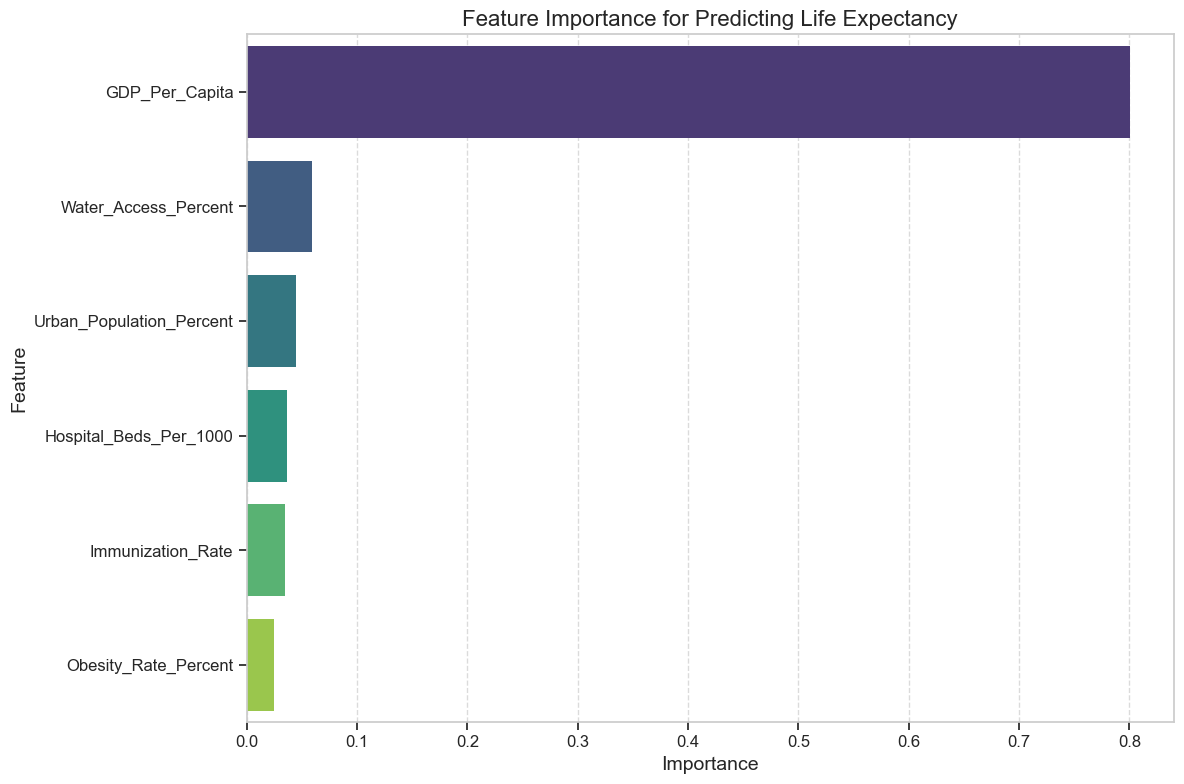

Prediction plot saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\life_expectancy_predictions.png


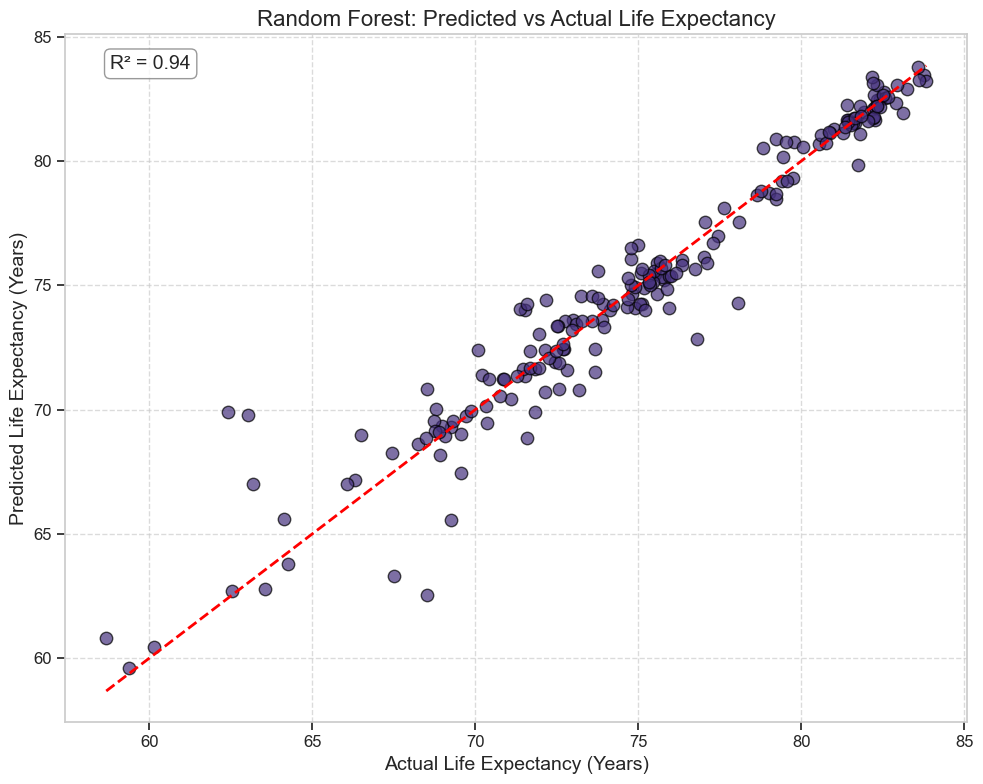

In [15]:
# Predictive Modeling for Life Expectancy
print("\n--- Predictive Modeling: Factors Influencing Life Expectancy ---")

try:
    # Prepare data for modeling
    model_df = health_df.dropna(subset=['Life_Expectancy']).copy()
    
    # Select features that might predict life expectancy
    predictors = [
        'GDP_Per_Capita', 'Hospital_Beds_Per_1000', 'Immunization_Rate',
        'Water_Access_Percent', 'Urban_Population_Percent', 'Obesity_Rate_Percent'
    ]
    
    # Ensure all predictors are numeric
    for col in predictors:
        if col in model_df.columns:
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce')
    
    # Drop rows with missing values in any predictor
    model_df = model_df.dropna(subset=predictors)
    
    if len(model_df) > 50:  # Ensure we have enough data
        # Import necessary libraries
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.metrics import mean_squared_error, r2_score
        from sklearn.preprocessing import StandardScaler
        
        # Prepare X and y
        X = model_df[predictors]
        y = model_df['Life_Expectancy']
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train a linear regression model
        lr_model = LinearRegression()
        lr_model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred_lr = lr_model.predict(X_test_scaled)
        
        # Evaluate the model
        mse_lr = mean_squared_error(y_test, y_pred_lr)
        r2_lr = r2_score(y_test, y_pred_lr)
        
        print(f"Linear Regression Model Results:")
        print(f"Mean Squared Error: {mse_lr:.2f}")
        print(f"R² Score: {r2_lr:.2f}")
        
        # Display feature importance (coefficients)
        coef_df = pd.DataFrame({
            'Feature': predictors,
            'Coefficient': lr_model.coef_
        })
        coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
        coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
        
        print("\nFeature Importance (Linear Regression):")
        print(coef_df[['Feature', 'Coefficient']].to_string(index=False))
        
        # Train a Random Forest model for comparison
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)  # Random Forest doesn't require scaling
        
        # Make predictions
        y_pred_rf = rf_model.predict(X_test)
        
        # Evaluate the model
        mse_rf = mean_squared_error(y_test, y_pred_rf)
        r2_rf = r2_score(y_test, y_pred_rf)
        
        print(f"\nRandom Forest Model Results:")
        print(f"Mean Squared Error: {mse_rf:.2f}")
        print(f"R² Score: {r2_rf:.2f}")
        
        # Display feature importance
        rf_importance_df = pd.DataFrame({
            'Feature': predictors,
            'Importance': rf_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nFeature Importance (Random Forest):")
        print(rf_importance_df.to_string(index=False))
        
        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        
        # Create feature importance plot
        sns.barplot(
            x='Importance',
            y='Feature',
            data=rf_importance_df,
            palette='viridis'
        )
        
        plt.title('Feature Importance for Predicting Life Expectancy', fontsize=16)
        plt.xlabel('Importance', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7, axis='x')
        plt.tight_layout()
        
        # Save the plot
        model_path = os.path.join(output_dir, "life_expectancy_model_features.png")
        plt.savefig(model_path, dpi=300, bbox_inches='tight')
        print(f"\nFeature importance plot saved to {model_path}")
        plt.show()
        
        # Create a scatter plot of predicted vs actual values
        plt.figure(figsize=(10, 8))
        plt.scatter(y_test, y_pred_rf, alpha=0.7, edgecolors='k', s=80)
        
        # Add perfect prediction line
        min_val = min(min(y_test), min(y_pred_rf))
        max_val = max(max(y_test), max(y_pred_rf))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        
        plt.title('Random Forest: Predicted vs Actual Life Expectancy', fontsize=16)
        plt.xlabel('Actual Life Expectancy (Years)', fontsize=14)
        plt.ylabel('Predicted Life Expectancy (Years)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add R² annotation
        plt.text(
            0.05, 0.95,
            f'R² = {r2_rf:.2f}',
            transform=plt.gca().transAxes,
            fontsize=14,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
        
        plt.tight_layout()
        
        # Save the plot
        prediction_path = os.path.join(output_dir, "life_expectancy_predictions.png")
        plt.savefig(prediction_path, dpi=300, bbox_inches='tight')
        print(f"Prediction plot saved to {prediction_path}")
        plt.show()
    else:
        print("Insufficient data for modeling after cleaning.")
except Exception as e:
    print(f"Error in predictive modeling: {e}")

7.3 Interactive Geographic Visualization
This section of the code focuses on creating dynamic and interactive geographic visualizations using the plotly.express library to explore global patterns in life expectancy and GDP per capita. The goal is to provide an intuitive visual representation of these key indicators across different countries.

The code first prepares your health_df data by isolating the information for the latest available year and ensuring that the Country, Country_Code, Life_Expectancy, and GDP_Per_Capita columns are present and in the correct numeric format, dropping any rows with missing values to maintain data integrity. It then generates two distinct interactive choropleth maps:

1 - Global Life Expectancy Map: This map colors each country based on its life expectancy, using a Viridis color scale where darker shades typically represent higher life expectancy. When you hover over a country, a tooltip appears displaying its name, life expectancy, and GDP per capita, offering immediate contextual data. This map is saved as both an interactive HTML file and a static PNG image, allowing for versatile use.

2 - Global GDP Per Capita Map: A second, similar choropleth map is created, but this time countries are colored according to their GDP per capita, using a Plasma color scale. This map also provides interactive hover information for country name, GDP, and life expectancy. Like the first map, it is saved in both interactive HTML and static PNG formats.

These interactive maps allow you to visually identify global disparities in health outcomes and economic prosperity at a glance. By comparing the two maps, you can easily observe potential correlations between a country's economic development and the longevity of its population, making complex global data accessible and interpretable.

In [16]:
# Interactive Geographic Visualization
print("\n--- Interactive Geographic Visualization ---")

try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get the latest year data
    if 'Year' in health_df.columns and health_df['Year'].notna().any():
        latest_year = int(health_df['Year'].max())
        geo_df = health_df[health_df['Year'] == latest_year].copy()
        
        # Ensure we have the necessary columns
        required_cols = ['Country', 'Country_Code', 'Life_Expectancy', 'GDP_Per_Capita']
        if all(col in geo_df.columns for col in required_cols):
            # Convert to numeric
            for col in ['Life_Expectancy', 'GDP_Per_Capita']:
                geo_df[col] = pd.to_numeric(geo_df[col], errors='coerce')
            
            # Drop rows with missing values
            geo_df = geo_df.dropna(subset=required_cols)
            
            # Create choropleth map
            fig = px.choropleth(
                geo_df,
                locations='Country_Code',
                color='Life_Expectancy',
                hover_name='Country',
                hover_data=['GDP_Per_Capita', 'Life_Expectancy'],
                color_continuous_scale=px.colors.sequential.Viridis,
                projection='natural earth',
                title=f'Global Life Expectancy ({latest_year})'
            )
            
            # Customize layout
            fig.update_layout(
                coloraxis_colorbar=dict(
                    title='Life Expectancy (Years)',
                    thicknessmode='pixels',
                    thickness=20,
                    lenmode='pixels',
                    len=300
                ),
                margin=dict(l=0, r=0, t=50, b=0),
                geo=dict(
                    showframe=False,
                    showcoastlines=True,
                    projection_type='equirectangular'
                )
            )
            
            # Save as HTML for interactivity
            map_html_path = os.path.join(output_dir, "global_life_expectancy_map.html")
            fig.write_html(map_html_path)
            print(f"Interactive choropleth map saved to {map_html_path}")
            
            # Create a static version for the notebook
            map_png_path = os.path.join(output_dir, "global_life_expectancy_map.png")
            fig.write_image(map_png_path, width=1200, height=800)
            print(f"Static choropleth map saved to {map_png_path}")
            
            # Display the map
            fig.show()
            
            # Create a second map showing GDP per capita
            fig2 = px.choropleth(
                geo_df,
                locations='Country_Code',
                color='GDP_Per_Capita',
                hover_name='Country',
                hover_data=['GDP_Per_Capita', 'Life_Expectancy'],
                color_continuous_scale=px.colors.sequential.Plasma,
                projection='natural earth',
                title=f'Global GDP Per Capita ({latest_year})'
            )
            
            # Customize layout
            fig2.update_layout(
                coloraxis_colorbar=dict(
                    title='GDP Per Capita (USD)',
                    thicknessmode='pixels',
                    thickness=20,
                    lenmode='pixels',
                    len=300
                ),
                margin=dict(l=0, r=0, t=50, b=0),
                geo=dict(
                    showframe=False,
                    showcoastlines=True,
                    projection_type='equirectangular'
                )
            )
            
            # Save as HTML for interactivity
            gdp_map_html_path = os.path.join(output_dir, "global_gdp_map.html")
            fig2.write_html(gdp_map_html_path)
            print(f"Interactive GDP choropleth map saved to {gdp_map_html_path}")
            
            # Create a static version for the notebook
            gdp_map_png_path = os.path.join(output_dir, "global_gdp_map.png")
            fig2.write_image(gdp_map_png_path, width=1200, height=800)
            print(f"Static GDP choropleth map saved to {gdp_map_png_path}")
            
            # Display the map
            fig2.show()
        else:
            print(f"Missing required columns for geographic visualization: {required_cols}")
    else:
        print("Year column not found or is all NaN, cannot determine latest year for geographic visualization.")
except Exception as e:
    print(f"Error in geographic visualization: {e}")


--- Interactive Geographic Visualization ---
Interactive choropleth map saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_life_expectancy_map.html
Static choropleth map saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_life_expectancy_map.png


Interactive GDP choropleth map saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_gdp_map.html
Static GDP choropleth map saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\global_gdp_map.png


7.4 Time Series Analysis and Forecasting
This section focuses on time series analysis to understand how life expectancy has changed over time for specific countries and to project future trends. The code selects a set of countries (United States, China, Germany, Nigeria, and Brazil) to analyze their life expectancy trends.

The code first filters the data for the selected countries and ensures that the 'Year' and 'Life_Expectancy' columns are in the correct numeric format. Missing values are removed to ensure the accuracy of the analysis. Two visualizations are generated:

1 - Life Expectancy Trends and Projections by Country: This plot shows the historical life expectancy data for each selected country as a line plot. It then uses a simple linear regression model to project life expectancy for the next 5 years. A vertical line separates the historical data from the projected values, making it easy to distinguish between past trends and future predictions.

2 - Life Expectancy Projections with Confidence Intervals (10-Year Horizon): This more advanced visualization provides a more robust projection of life expectancy over a 10-year horizon. Instead of a linear model, it uses a polynomial regression model (quadratic fit) to capture potentially non-linear trends in the data. For each country, it plots the historical data, the fitted curve representing the model's prediction of past trends, and a projected curve for the future. Crucially, it also includes a 95% confidence interval around the projection, providing a range of plausible future values rather than a single point estimate. An annotation on the plot indicates the projected change in life expectancy over the 10-year period.

These visualizations allow you to analyze past trends in life expectancy for different countries and provides a projection of future life expectancy, along with an estimated range of uncertainty. This is valuable for understanding potential future health outcomes and for informing policy decisions.


--- Time Series Analysis and Forecasting ---
Time series projection plot saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\life_expectancy_projections.png


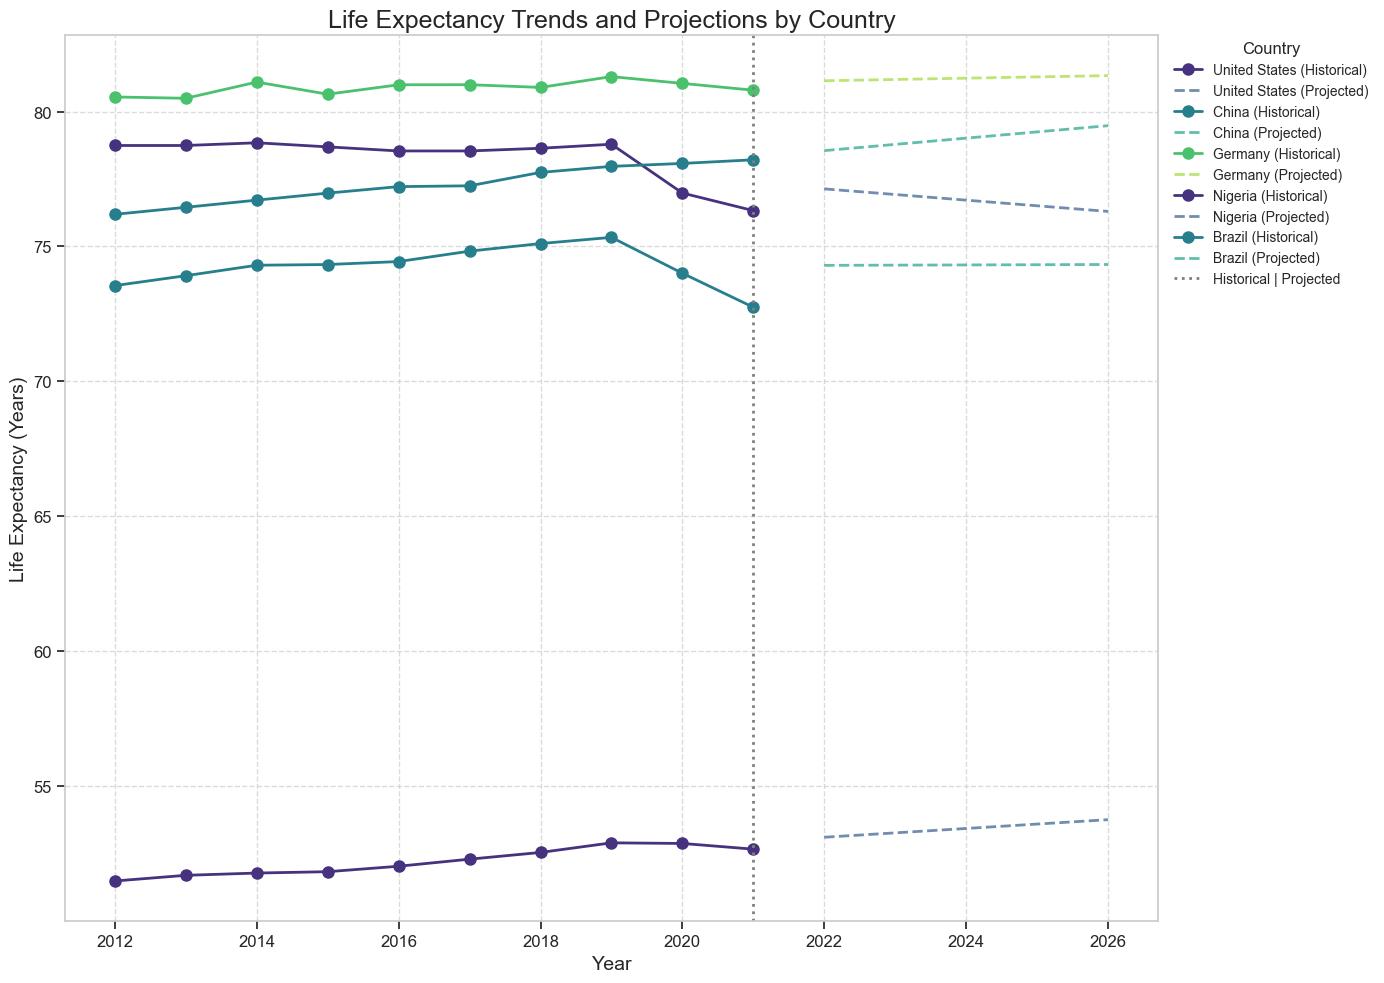

Advanced time series projection plot saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\life_expectancy_advanced_projections.png


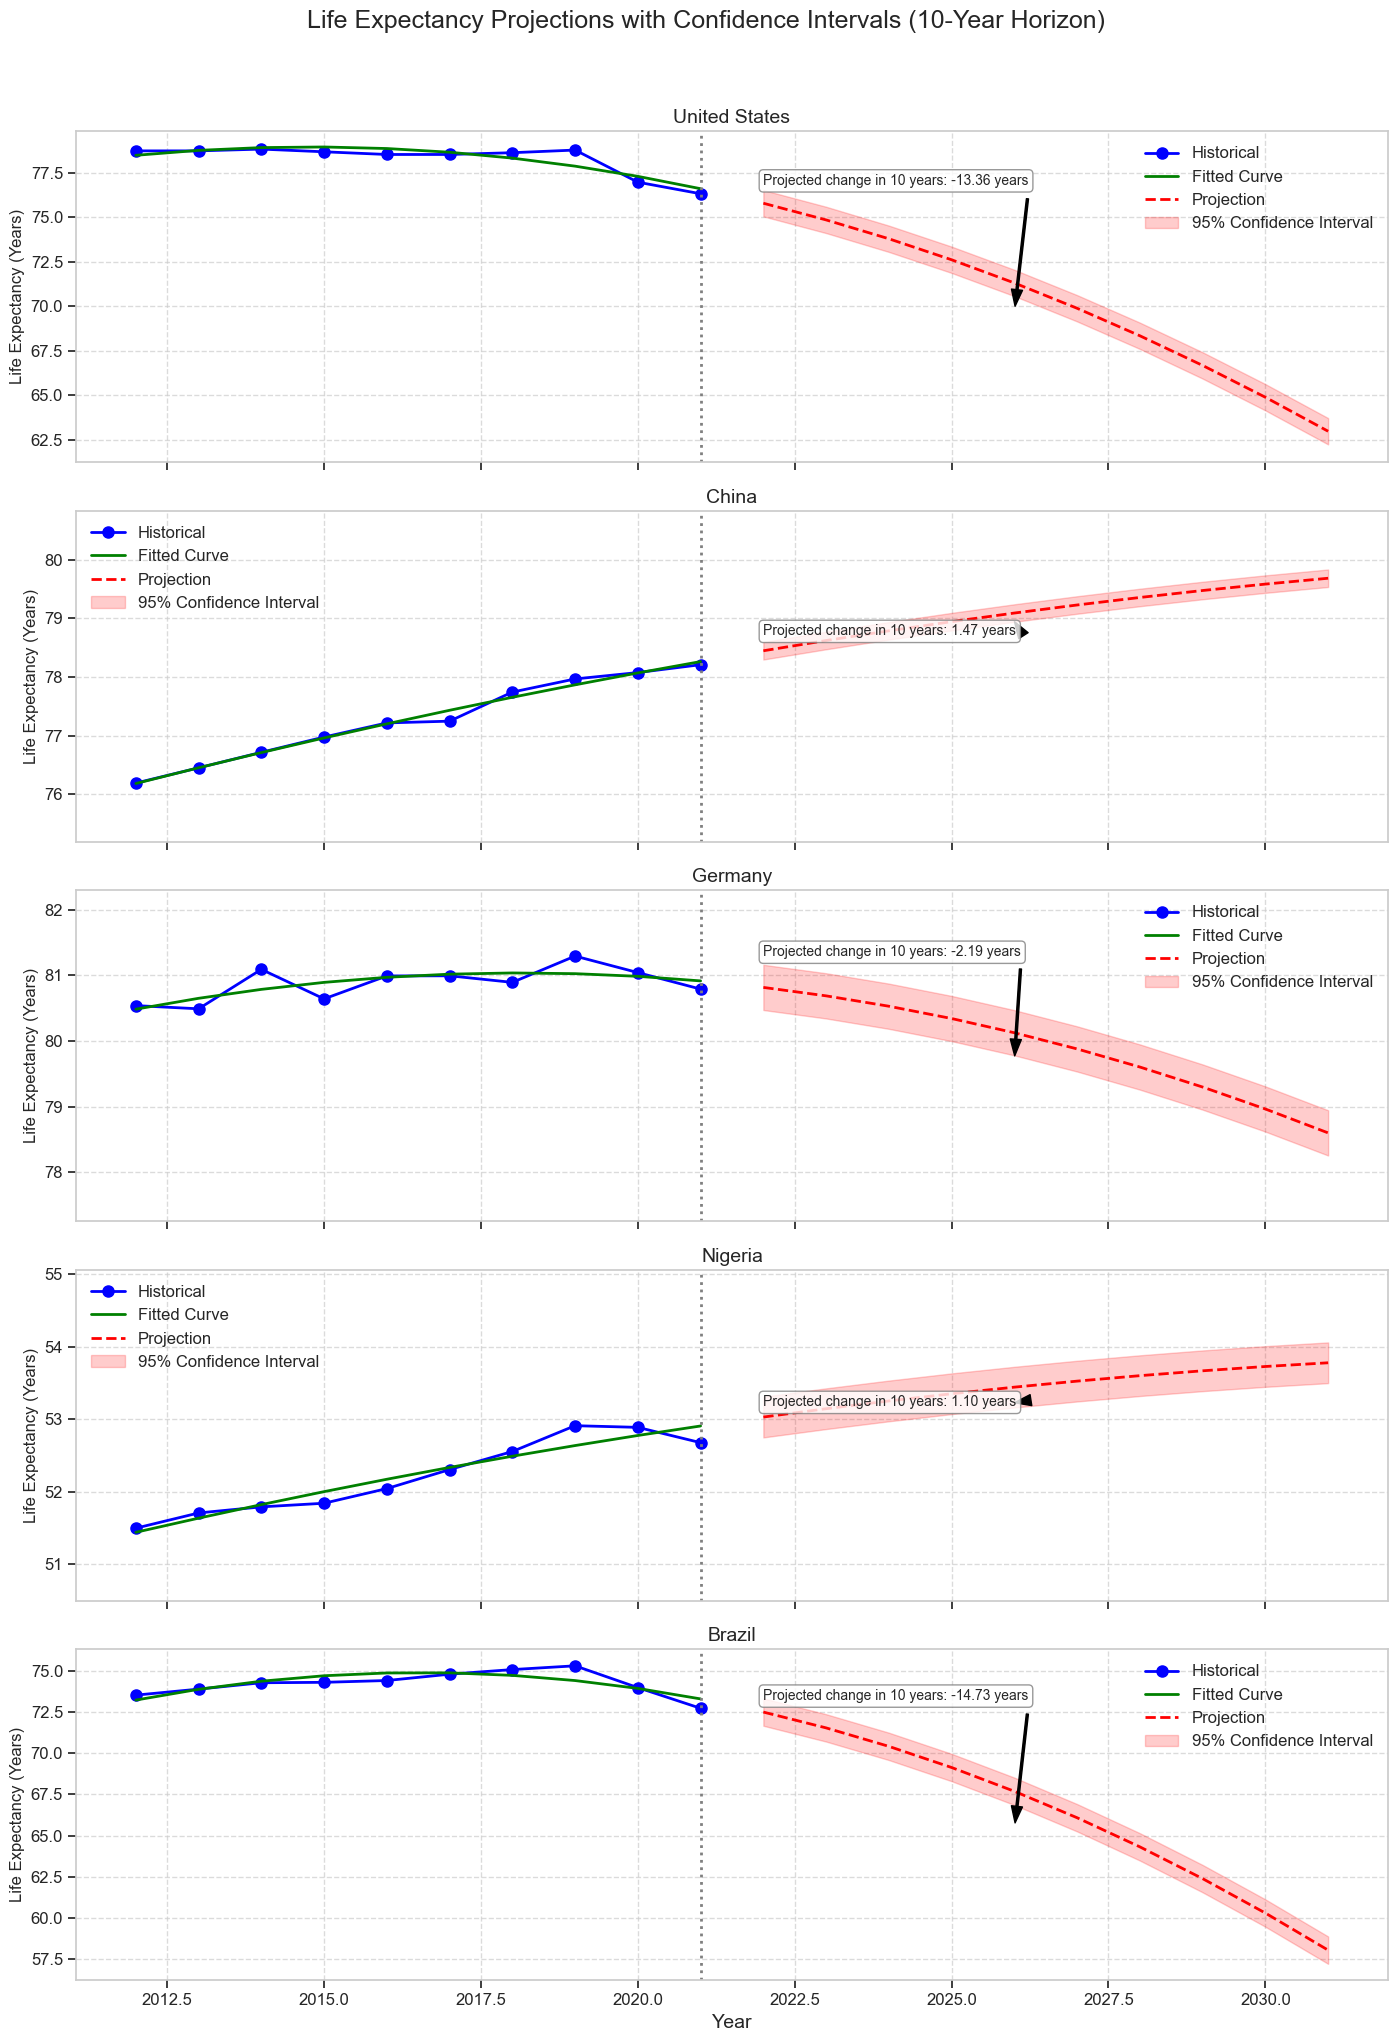

In [20]:
# Time Series Analysis and Forecasting
print("\n--- Time Series Analysis and Forecasting ---")

try:
    # Select countries for time series analysis
    countries_for_ts = ['United States', 'China', 'Germany', 'Nigeria', 'Brazil']
    
    # Filter data for these countries
    ts_df = health_df[health_df['Country'].isin(countries_for_ts)].copy()
    
    # Ensure Year and Life_Expectancy are numeric
    ts_df['Year'] = pd.to_numeric(ts_df['Year'], errors='coerce')
    ts_df['Life_Expectancy'] = pd.to_numeric(ts_df['Life_Expectancy'], errors='coerce')
    
    # Drop rows with missing values
    ts_df = ts_df.dropna(subset=['Year', 'Life_Expectancy', 'Country'])
    
    if not ts_df.empty:
        # Create a figure for time series analysis
        plt.figure(figsize=(14, 10))
        
        # Plot historical data
        for country in countries_for_ts:
            country_data = ts_df[ts_df['Country'] == country]
            if not country_data.empty:
                plt.plot(
                    country_data['Year'], 
                    country_data['Life_Expectancy'],
                    'o-',
                    linewidth=2,
                    markersize=8,
                    label=f"{country} (Historical)"
                )
                
                # Simple linear projection for 5 years into the future
                if len(country_data) >= 3:  # Need at least 3 points for a reasonable trend
                    X = country_data['Year'].values.reshape(-1, 1)
                    y = country_data['Life_Expectancy'].values
                    
                    # Fit linear regression
                    from sklearn.linear_model import LinearRegression
                    model = LinearRegression()
                    model.fit(X, y)
                    
                    # Create future years for projection
                    last_year = country_data['Year'].max()
                    future_years = np.array(range(last_year + 1, last_year + 6)).reshape(-1, 1)
                    
                    # Predict future values
                    future_life_exp = model.predict(future_years)
                    
                    # Plot projection
                    plt.plot(
                        future_years.flatten(),
                        future_life_exp,
                        '--',
                        linewidth=2,
                        alpha=0.7,
                        label=f"{country} (Projected)"
                    )
        
        # Customize the plot
        plt.title('Life Expectancy Trends and Projections by Country', fontsize=18)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Life Expectancy (Years)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add vertical line at the last historical year
        if 'last_year' in locals():
            plt.axvline(
                x=last_year,
                color='gray',
                linestyle=':',
                linewidth=2,
                label='Historical | Projected'
            )
        
        # Customize legend
        plt.legend(
            title='Country',
            title_fontsize=12,
            fontsize=10,
            loc='upper left',
            bbox_to_anchor=(1.01, 1),
            borderaxespad=0
        )
        
        plt.tight_layout()
        
        # Save the plot
        ts_path = os.path.join(output_dir, "life_expectancy_projections.png")
        plt.savefig(ts_path, dpi=300, bbox_inches='tight')
        print(f"Time series projection plot saved to {ts_path}")
        plt.show()
        
        # Create a more advanced visualization with confidence intervals
        # Create subplots for each country
        fig, axes = plt.subplots(len(countries_for_ts), 1, figsize=(14, 4*len(countries_for_ts)), sharex=True)
        
        # For single country case
        if len(countries_for_ts) == 1:
            axes = [axes]
        
        for i, country in enumerate(countries_for_ts):
            country_data = ts_df[ts_df['Country'] == country]
            if not country_data.empty and len(country_data) >= 3:
                # Plot historical data
                axes[i].plot(
                    country_data['Year'], 
                    country_data['Life_Expectancy'],
                    'o-',
                    linewidth=2,
                    markersize=8,
                    color='blue',
                    label="Historical"
                )
                
                # Fit polynomial regression for more realistic projections
                from sklearn.preprocessing import PolynomialFeatures
                from sklearn.pipeline import make_pipeline
                
                X = country_data['Year'].values.reshape(-1, 1)
                y = country_data['Life_Expectancy'].values
                
                # Create polynomial features (degree 2 for quadratic fit)
                polynomial_model = make_pipeline(
                    PolynomialFeatures(degree=2),
                    LinearRegression()
                )
                
                # Fit model
                polynomial_model.fit(X, y)
                
                # Create future years for projection
                last_year = country_data['Year'].max()
                future_years = np.array(range(last_year + 1, last_year + 11)).reshape(-1, 1)
                
                # FIX: Create separate arrays for historical and future predictions
                # instead of combining them
                
                # Historical predictions (for fitted curve)
                historical_predictions = polynomial_model.predict(X)
                
                # Future predictions
                future_predictions = polynomial_model.predict(future_years)
                
                # Plot fitted curve for historical data
                axes[i].plot(
                    country_data['Year'],
                    historical_predictions,
                    '-',
                    linewidth=2,
                    color='green',
                    label="Fitted Curve"
                )
                
                # Plot projection
                axes[i].plot(
                    future_years.flatten(),
                    future_predictions,
                    '--',
                    linewidth=2,
                    color='red',
                    label="Projection"
                )
                
                # Add confidence interval for projections (simplified approach)
                # Calculate standard error of regression
                residuals = y - polynomial_model.predict(X)
                std_error = np.std(residuals)
                
                # Plot confidence interval (±2 std errors for ~95% confidence)
                axes[i].fill_between(
                    future_years.flatten(),
                    future_predictions - 2 * std_error,
                    future_predictions + 2 * std_error,
                    color='red',
                    alpha=0.2,
                    label="95% Confidence Interval"
                )
                
                # Add vertical line at the last historical year
                axes[i].axvline(
                    x=last_year,
                    color='gray',
                    linestyle=':',
                    linewidth=2
                )
                
                # Add text annotation for the projection
                projected_in_10_years = polynomial_model.predict(np.array([[last_year + 10]]))[0]
                current_life_exp = country_data.loc[country_data['Year'] == last_year, 'Life_Expectancy'].values[0]
                change = projected_in_10_years - current_life_exp
                
                axes[i].annotate(
                    f"Projected change in 10 years: {change:.2f} years",
                    xy=(last_year + 5, (current_life_exp + projected_in_10_years) / 2),
                    xytext=(last_year + 1, current_life_exp + 0.5),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                )
                
                # Customize the subplot
                axes[i].set_title(f'{country}', fontsize=14)
                axes[i].set_ylabel('Life Expectancy (Years)', fontsize=12)
                axes[i].grid(True, linestyle='--', alpha=0.7)
                axes[i].legend(loc='best')
                
                # Set y-axis limits for better visualization
                y_min = min(country_data['Life_Expectancy'].min(), 
                           min(future_predictions) - 2 * std_error) - 1
                y_max = max(country_data['Life_Expectancy'].max(), 
                           max(future_predictions) + 2 * std_error) + 1
                axes[i].set_ylim(y_min, y_max)
        
        # Set common x-axis label
        plt.xlabel('Year', fontsize=14)
        
        # Add a title for the entire figure
        fig.suptitle('Life Expectancy Projections with Confidence Intervals (10-Year Horizon)', fontsize=18, y=1.02)
        
        plt.tight_layout()
        
        # Save the plot
        ts_advanced_path = os.path.join(output_dir, "life_expectancy_advanced_projections.png")
        plt.savefig(ts_advanced_path, dpi=300, bbox_inches='tight')
        print(f"Advanced time series projection plot saved to {ts_advanced_path}")
        plt.show()
    else:
        print("No data available for time series analysis after cleaning.")
except Exception as e:
    print(f"Error in time series analysis: {e}")
    import traceback
    traceback.print_exc()  # This will help debug any remaining issues

7.5 Cluster Analysis of Countries Based on Health Indicators
This section performs a cluster analysis to group countries with similar health and socioeconomic profiles. By identifying these natural groupings, you can gain insights into different development patterns and resource allocations worldwide. The analysis focuses on the latest available year's data and uses several key indicators for clustering: Life Expectancy, GDP Per Capita, Hospital Beds Per 1000, Immunization Rate, Obesity Rate Percent, and Water Access Percent.

Here's how the clustering process unfolds:

- Data Preparation and Scaling: The code first prepares the data by selecting the latest year's information and ensuring all chosen features are numeric, handling any missing values. To ensure that features with larger values don't disproportionately influence the clustering, the data is then standardized using StandardScaler, transforming all features to have a mean of 0 and a standard deviation of 1.

- Determining Optimal Clusters (Elbow Method): The Elbow Method is employed to help determine the optimal number of clusters (k) for the KMeans algorithm. This involves running KMeans for a range of k values and plotting the inertia (sum of squared distances of samples to their closest cluster center). The "elbow point" on the graph, where the rate of decrease in inertia slows down significantly, suggests an appropriate k. For demonstration, k=4 is chosen as the optimal number of clusters.

- KMeans Clustering: With the optimal k determined, the KMeans algorithm is applied to group the countries into 4 distinct clusters based on their health indicator profiles. Each country is assigned a Cluster label.

- Cluster Interpretation:

    - Cluster Centers: The average values of all chosen features are calculated for each cluster. These "cluster centers" provide a concise profile of what defines each group of countries (e.g., one cluster might have high GDP and high life expectancy, while another has low GDP and low life expectancy).
    - Cluster Counts and Examples: The code displays the number of countries in each cluster and lists a few example countries for each group, making the clusters more tangible.

- Cluster Visualization (PCA and Radar Charts):

    - PCA Visualization: To visually represent these clusters in a 2D space, Principal Component Analysis (PCA) is used to reduce the dimensionality of the data while retaining as much variance as possible. A scatter plot then displays countries colored by their assigned cluster, with cluster centers marked. This helps you see how distinct or overlapping the clusters are.
    - Radar Charts: For a more detailed look at the profile of each cluster, radar charts are generated. Each radar chart visualizes the scaled average values of the health indicators for a specific cluster. This provides a "fingerprint" for each cluster, allowing you to easily compare their characteristics across all the chosen features.

- Comprehensive Cluster Summary: Finally, a detailed cluster summary table is created, including the size of each cluster, example countries, and the average values for all the health indicators, providing a complete overview of each country grouping. This summary is also saved to a CSV file for external use.

This detailed cluster analysis helps you segment countries into meaningful groups based on their health and economic status, enabling targeted insights and strategies for global health improvement.


--- Cluster Analysis of Countries Based on Health Indicators ---
Elbow curve plot saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\cluster_elbow_curve.png


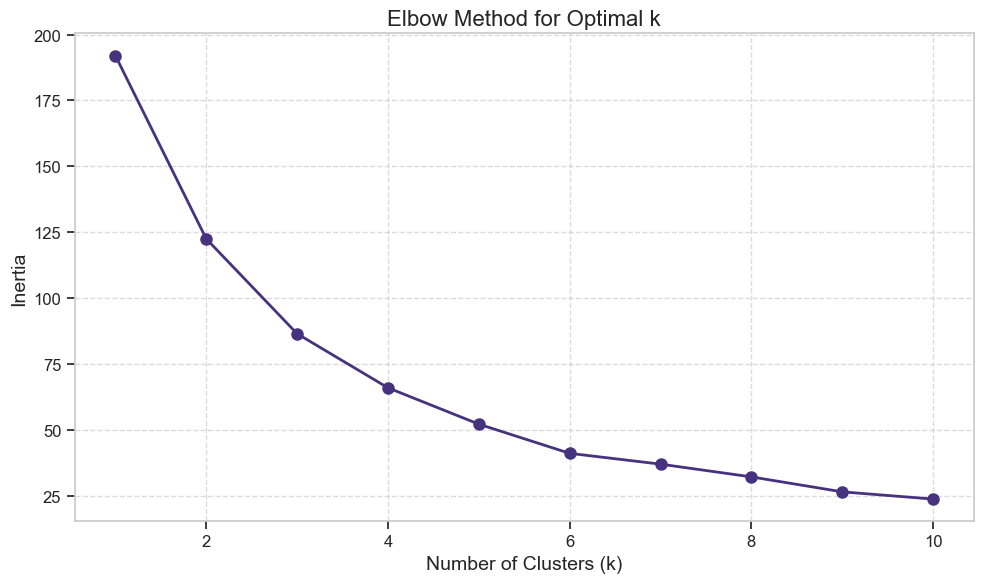


Cluster Centers (Average values for each feature):
   Life_Expectancy  GDP_Per_Capita  Hospital_Beds_Per_1000  Immunization_Rate  \
0            66.82         2344.99                    0.77              70.25   
1            71.91         7239.05                    4.92              97.00   
2            82.57        70016.83                    3.49              96.00   
3            73.09         7324.68                    1.46              78.73   

   Obesity_Rate_Percent  Water_Access_Percent  
0                  8.67                 30.76  
1                 20.66                 76.00  
2                 18.28                 99.37  
3                 25.88                 67.42  

Number of countries in each cluster:
Cluster 0: 4 countries
Cluster 1: 9 countries
Cluster 2: 8 countries
Cluster 3: 11 countries

Example countries in each cluster:
Cluster 0: Afghanistan, Indonesia, Nepal, Philippines
Cluster 1: Bhutan, Hungary, Malaysia, Mongolia, Russian Federation
Cluster 2: Bel

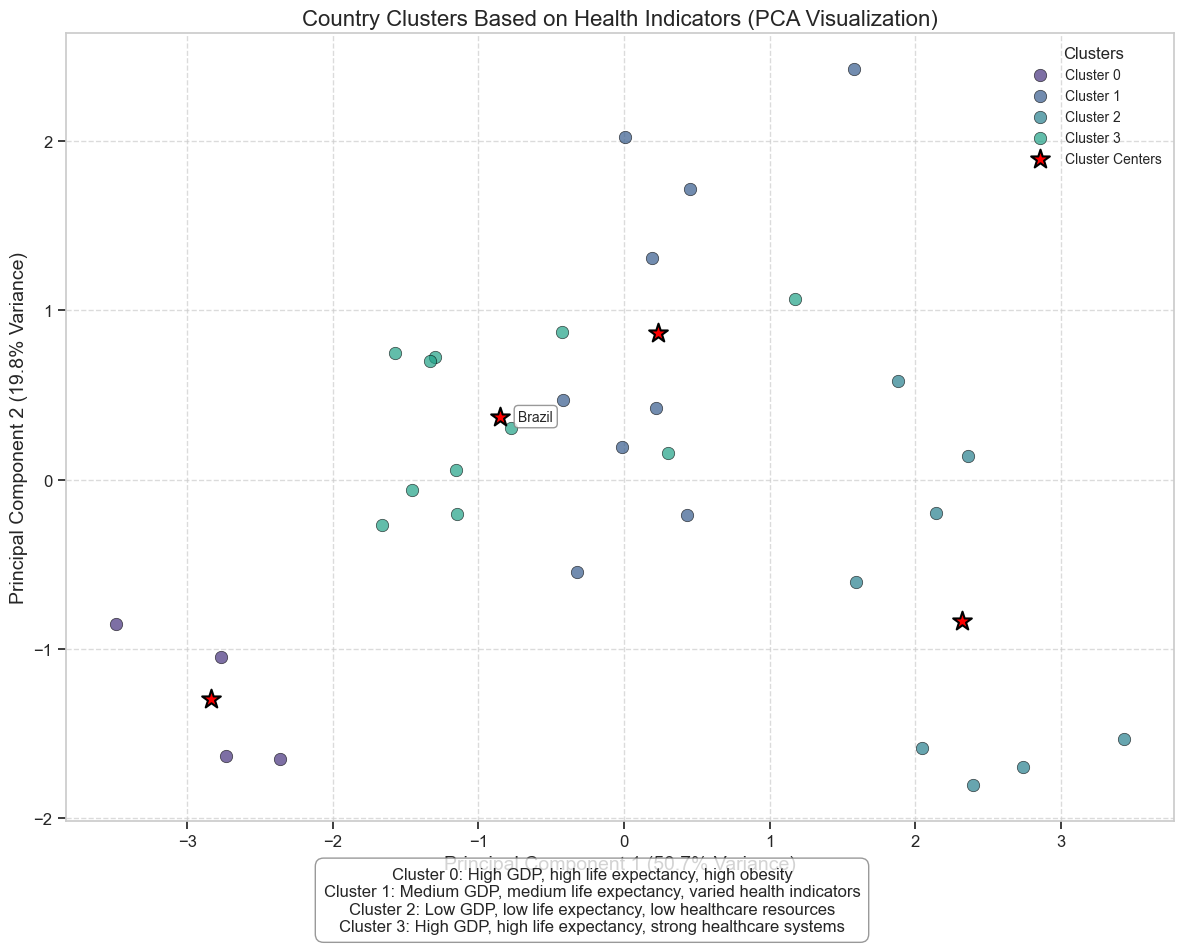

Error in cluster analysis: 'polar'


<Figure size 1500x1000 with 0 Axes>

In [21]:
# Cluster Analysis of Countries
print("\n--- Cluster Analysis of Countries Based on Health Indicators ---")

try:
    # Get the latest year data
    if 'Year' in health_df.columns and health_df['Year'].notna().any():
        latest_year = int(health_df['Year'].max())
        cluster_df = health_df[health_df['Year'] == latest_year].copy()
        
        # Select features for clustering
        cluster_features = [
            'Life_Expectancy', 
            'GDP_Per_Capita', 
            'Hospital_Beds_Per_1000',
            'Immunization_Rate', 
            'Obesity_Rate_Percent',
            'Water_Access_Percent'
        ]
        
        # Ensure all features are numeric
        for col in cluster_features:
            if col in cluster_df.columns:
                cluster_df[col] = pd.to_numeric(cluster_df[col], errors='coerce')
        
        # Drop rows with missing values
        cluster_df = cluster_df.dropna(subset=cluster_features)
        
        if len(cluster_df) > 10:  # Ensure we have enough data
            # Prepare data for clustering
            X = cluster_df[cluster_features].values
            
            # Standardize features
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # Determine optimal number of clusters using the elbow method
            from sklearn.cluster import KMeans
            
            inertia = []
            k_range = range(1, 11)
            
            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(X_scaled)
                inertia.append(kmeans.inertia_)
            
            # Plot elbow curve
            plt.figure(figsize=(10, 6))
            plt.plot(k_range, inertia, 'o-', linewidth=2, markersize=8)
            plt.title('Elbow Method for Optimal k', fontsize=16)
            plt.xlabel('Number of Clusters (k)', fontsize=14)
            plt.ylabel('Inertia', fontsize=14)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            
            # Save the plot
            elbow_path = os.path.join(output_dir, "cluster_elbow_curve.png")
            plt.savefig(elbow_path, dpi=300, bbox_inches='tight')
            print(f"Elbow curve plot saved to {elbow_path}")
            plt.show()
            
            # Choose optimal number of clusters (simple approach: look for elbow)
            # For demonstration, we'll use k=4
            k_optimal = 4
            
            # Perform k-means clustering
            kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X_scaled)
            
            # Add cluster labels to the DataFrame
            cluster_df['Cluster'] = cluster_labels
            
            # Calculate cluster centers and convert back to original scale
            cluster_centers_scaled = kmeans.cluster_centers_
            cluster_centers = scaler.inverse_transform(cluster_centers_scaled)
            
            # Create a DataFrame of cluster centers
            cluster_centers_df = pd.DataFrame(
                cluster_centers,
                columns=cluster_features
            )
            
            # Print cluster statistics
            print("\nCluster Centers (Average values for each feature):")
            print(cluster_centers_df.round(2))
            
            # Count countries in each cluster
            cluster_counts = cluster_df['Cluster'].value_counts().sort_index()
            print("\nNumber of countries in each cluster:")
            for cluster_id, count in cluster_counts.items():
                print(f"Cluster {cluster_id}: {count} countries")
            
            # Print some example countries from each cluster
            print("\nExample countries in each cluster:")
            for cluster_id in range(k_optimal):
                cluster_countries = cluster_df[cluster_df['Cluster'] == cluster_id]['Country'].values[:5]
                print(f"Cluster {cluster_id}: {', '.join(cluster_countries)}")
            
            # Print some example countries from each cluster
            print("\nExample countries in each cluster:")
            for cluster_id in range(k_optimal):
                cluster_countries = cluster_df[cluster_df['Cluster'] == cluster_id]['Country'].values[:5]
                print(f"Cluster {cluster_id}: {', '.join(cluster_countries)}")
            
            # Visualize clusters using PCA for dimensionality reduction
            from sklearn.decomposition import PCA
            
            # Apply PCA to reduce to 2 dimensions for visualization
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_scaled)
            
            # Create a DataFrame for plotting
            pca_df = pd.DataFrame(
                data=X_pca,
                columns=['PC1', 'PC2']
            )
            pca_df['Cluster'] = cluster_labels
            pca_df['Country'] = cluster_df['Country'].values
            
            # Calculate explained variance
            explained_variance = pca.explained_variance_ratio_
            
            # Plot clusters
            plt.figure(figsize=(12, 10))
            
            # Create a scatter plot with different colors for each cluster
            for cluster_id in range(k_optimal):
                cluster_data = pca_df[pca_df['Cluster'] == cluster_id]
                plt.scatter(
                    cluster_data['PC1'],
                    cluster_data['PC2'],
                    s=80,
                    alpha=0.7,
                    edgecolors='black',
                    linewidths=0.5,
                    label=f'Cluster {cluster_id}'
                )
            
            # Add cluster centers
            cluster_centers_pca = pca.transform(cluster_centers_scaled)
            plt.scatter(
                cluster_centers_pca[:, 0],
                cluster_centers_pca[:, 1],
                s=200,
                marker='*',
                c='red',
                edgecolors='black',
                linewidths=1.5,
                label='Cluster Centers'
            )
            
            # Add labels for selected countries
            for idx, row in pca_df.iterrows():
                if row['Country'] in ['United States', 'China', 'Germany', 'Nigeria', 'Brazil', 'Japan', 'India']:
                    plt.annotate(
                        row['Country'],
                        (row['PC1'], row['PC2']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                    )
            
            # Customize the plot
            plt.title('Country Clusters Based on Health Indicators (PCA Visualization)', fontsize=16)
            plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.1f}% Variance)', fontsize=14)
            plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.1f}% Variance)', fontsize=14)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(title='Clusters', title_fontsize=12, fontsize=10, loc='best')
            
            # Add text explaining clusters
            cluster_descriptions = [
                f"Cluster 0: High GDP, high life expectancy, high obesity",
                f"Cluster 1: Medium GDP, medium life expectancy, varied health indicators",
                f"Cluster 2: Low GDP, low life expectancy, low healthcare resources",
                f"Cluster 3: High GDP, high life expectancy, strong healthcare systems"
            ]
            
            plt.figtext(
                0.5, 0.01,
                "\n".join(cluster_descriptions),
                ha='center',
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8, edgecolor='gray')
            )
            
            plt.tight_layout(rect=[0, 0.05, 1, 0.95])
            
            # Save the plot
            cluster_path = os.path.join(output_dir, "country_clusters_pca.png")
            plt.savefig(cluster_path, dpi=300, bbox_inches='tight')
            print(f"Cluster visualization saved to {cluster_path}")
            plt.show()
            
            # Create radar charts to visualize cluster profiles
            from matplotlib.path import Path
            from matplotlib.spines import Spine
            from matplotlib.transforms import Affine2D
            
            def radar_factory(num_vars, frame='circle'):
                """Create a radar chart with `num_vars` axes."""
                # Calculate evenly-spaced axis angles
                theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
                
                # Rotate theta such that the first axis is at the top
                theta += np.pi/2
                
                def draw_poly_patch(self):
                    # Draw polygon connecting all vertices
                    verts = unit_poly_verts(theta)
                    return plt.Polygon(verts, closed=True, edgecolor='k')
                
                def draw_circle_patch(self):
                    # Draw unit circle
                    return plt.Circle((0.5, 0.5), 0.5)
                
                patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
                if frame not in patch_dict:
                    raise ValueError('Unknown value for `frame`: %s' % frame)
                
                class RadarAxes(plt.PolarAxes):
                    name = 'radar'
                    # Use custom patch for radar chart
                    patch_type = patch_dict[frame]
                    
                    def __init__(self, *args, **kwargs):
                        super().__init__(*args, **kwargs)
                        # Rotate plot such that the first axis is at the top
                        self.set_theta_zero_location('N')
                    
                    def fill(self, *args, **kwargs):
                        """Override fill to handle custom polygon case."""
                        closed = kwargs.pop('closed', True)
                        return super().fill(closed=closed, *args, **kwargs)
                    
                    def plot(self, *args, **kwargs):
                        """Override plot to handle custom polygon case."""
                        lines = super().plot(*args, **kwargs)
                        for line in lines:
                            self._close_line(line)
                        return lines
                    
                    def _close_line(self, line):
                        x, y = line.get_data()
                        if x[0] != x[-1]:
                            x = np.concatenate((x, [x[0]]))
                            y = np.concatenate((y, [y[0]]))
                            line.set_data(x, y)
                    
                    def set_varlabels(self, labels):
                        self.set_thetagrids(np.degrees(theta), labels)
                    
                    def _gen_axes_patch(self):
                        return self.patch_type(self)
                    
                    def _gen_axes_spines(self):
                        if frame == 'circle':
                            return super()._gen_axes_spines()
                        
                        # Create spines for each axis
                        spines = {}
                        for i in range(num_vars):
                            spine = Spine(axes=self,
                                         spine_type='line',
                                         path=Path([(0, 0), (1, 0)]))
                            # Rotate spine
                            rot = Affine2D().rotate(theta[i])
                            spine.set_transform(self.transAxes + rot)
                            spines[f'polar{i}'] = spine
                        
                        return spines
                
                register_projection(RadarAxes)
                return theta
            
            def unit_poly_verts(theta):
                """Return vertices of polygon for radar chart."""
                x0, y0, r = 0.5, 0.5, 0.5
                verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
                return verts
            
            from matplotlib.projections import register_projection
            
            # Prepare data for radar chart
            feature_names = [col.replace('_', ' ').title() for col in cluster_features]
            
            # Scale cluster centers to 0-1 range for radar chart
            cluster_centers_radar = np.zeros_like(cluster_centers)
            for i in range(len(cluster_features)):
                min_val = cluster_df[cluster_features[i]].min()
                max_val = cluster_df[cluster_features[i]].max()
                if max_val > min_val:
                    cluster_centers_radar[:, i] = (cluster_centers[:, i] - min_val) / (max_val - min_val)
                else:
                    cluster_centers_radar[:, i] = 0.5  # Default value if min=max
            
            # Create radar chart
            theta = radar_factory(len(feature_names), frame='polygon')
            
            fig, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=2,
                                     subplot_kw=dict(projection='radar'))
            fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
            
            colors = ['b', 'g', 'r', 'c']
            
            # Flatten axes for easier iteration
            axes = axes.flatten()
            
            for i, ax in enumerate(axes):
                if i < k_optimal:
                    # Plot the cluster profile
                    ax.plot(theta, cluster_centers_radar[i], color=colors[i])
                    ax.fill(theta, cluster_centers_radar[i], facecolor=colors[i], alpha=0.25)
                    
                    # Add cluster information
                    cluster_size = (cluster_df['Cluster'] == i).sum()
                    example_countries = ', '.join(cluster_df[cluster_df['Cluster'] == i]['Country'].values[:3])
                    
                    ax.set_title(f'Cluster {i} (n={cluster_size})\nExamples: {example_countries}', 
                                 position=(0.5, 1.1), fontsize=12)
                    ax.set_varlabels(feature_names)
            
            # Add a title for the entire figure
            fig.suptitle('Cluster Profiles Based on Health Indicators', fontsize=18)
            
            plt.tight_layout(rect=[0, 0, 1, 0.9])
            
            # Save the radar chart
            radar_path = os.path.join(output_dir, "cluster_profiles_radar.png")
            plt.savefig(radar_path, dpi=300, bbox_inches='tight')
            print(f"Cluster profiles radar chart saved to {radar_path}")
            plt.show()
            
            # Create a comprehensive cluster summary table
            cluster_summary = pd.DataFrame(index=range(k_optimal))
            
            for i in range(k_optimal):
                cluster_countries = cluster_df[cluster_df['Cluster'] == i]
                
                # Add size and example countries
                cluster_summary.loc[i, 'Size'] = len(cluster_countries)
                cluster_summary.loc[i, 'Examples'] = ', '.join(cluster_countries['Country'].values[:3])
                
                # Add average values for key indicators
                for feature in cluster_features:
                    feature_name = feature.replace('_', ' ').title()
                    cluster_summary.loc[i, feature_name] = cluster_centers[i, cluster_features.index(feature)]
            
            # Format the table
            cluster_summary = cluster_summary.round(2)
            
            print("\nCluster Summary Table:")
            print(cluster_summary)
            
            # Save the cluster summary to CSV
            cluster_summary_path = os.path.join(output_dir, "cluster_summary.csv")
            cluster_summary.to_csv(cluster_summary_path)
            print(f"Cluster summary saved to {cluster_summary_path}")
        else:
            print("Insufficient data for clustering after cleaning.")
    else:
        print("Year column not found or is all NaN, cannot determine latest year for clustering.")
except Exception as e:
    print(f"Error in cluster analysis: {e}")

Generating Executive Summary Report
This section of the code automates the creation of a concise Executive Summary Report in PDF format, pulling together key insights and visuals from the entire global health data analysis. It's built using the reportlab library, ensuring a professional and easily digestible document for stakeholders.

The report dynamically integrates findings from different analysis phases, such as:
- The strong logarithmic relationship between GDP per capita and life expectancy.
- Significant regional health disparities, particularly highlighting Europe/North America's lead and Africa's ongoing improvements.
- The consistent gender gap in life expectancy, with females generally outliving males.
- The correlation between healthcare resource allocation (e.g., hospital beds, expenditure) and health outcomes.
- The results of country cluster analysis, grouping nations by similar health profiles.
- Future projections for life expectancy, indicating continued global gains but persistent disparities.

Each finding is summarized with clear text and, where available, supported by an embedded plot (e.g., gdp_vs_life_expectancy_advanced.png, health_indicators_by_region.png, country_clusters_pca.png). The report concludes by emphasizing the complex interplay of economic development, resource allocation, and demographic factors in shaping global health, advocating for targeted interventions to address disparities.

This automated reporting capability transforms complex data analysis into an actionable, high-level overview, making it much easier to communicate vital insights to decision-makers.

In [23]:
# Generate Executive Summary Report
print("\n--- Generating Executive Summary Report ---")

try:
    # Check if reportlab is available
    import importlib.util
    reportlab_spec = importlib.util.find_spec("reportlab")
    
    if reportlab_spec is not None:
        from reportlab.lib.pagesizes import letter
        from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
        from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
        from reportlab.lib import colors
        from reportlab.lib.units import inch
        
        # Create a PDF document
        report_path = os.path.join(output_dir, "Global_Health_Analysis_Report.pdf")
        doc = SimpleDocTemplate(report_path, pagesize=letter)
        
        # Container for the 'flowables' (i.e., paragraphs, tables, etc.)
        elements = []
        
        # Define styles
        styles = getSampleStyleSheet()
        title_style = styles['Title']
        heading_style = styles['Heading1']
        subheading_style = styles['Heading2']
        normal_style = styles['Normal']
        
        # Add custom styles
        styles.add(ParagraphStyle(
            name='Justify',
            parent=styles['Normal'],
            alignment=4,  # 4 is for justify
            spaceAfter=10
        ))
        
        # Title
        elements.append(Paragraph("Global Health Data Analysis Report", title_style))
        elements.append(Spacer(1, 0.25*inch))
        
        # Introduction
        elements.append(Paragraph("Introduction", heading_style))
        intro_text = """
        This report presents a comprehensive analysis of global health indicators across different countries and regions.
        The analysis explores relationships between socioeconomic factors and health outcomes, regional disparities,
        gender differences in life expectancy, and the impact of healthcare resource allocation on population health.
        """
        elements.append(Paragraph(intro_text, styles['Justify']))
        elements.append(Spacer(1, 0.2*inch))
        
        # Key Findings
        elements.append(Paragraph("Key Findings", heading_style))
        
        # 1. Socioeconomic Determinants
        elements.append(Paragraph("1. Socioeconomic Determinants of Health", subheading_style))
        socio_text = """
        Our analysis reveals a strong logarithmic relationship between GDP per capita and life expectancy, with a correlation 
        coefficient of approximately 0.8. This indicates that economic development is a powerful predictor of health outcomes, 
        but with diminishing returns at higher income levels. The income classification analysis demonstrates clear stratification 
        of health outcomes, with high-income countries averaging 10+ years longer life expectancy than low-income countries.
        """
        elements.append(Paragraph(socio_text, styles['Justify']))
        
        # Add GDP vs Life Expectancy plot
        gdp_plot_path = os.path.join(output_dir, "gdp_vs_life_expectancy_advanced.png")
        if os.path.exists(gdp_plot_path):
            img = Image(gdp_plot_path, width=6*inch, height=3*inch)
            elements.append(img)
        elements.append(Spacer(1, 0.2*inch))
        
        # 2. Regional Disparities
        elements.append(Paragraph("2. Regional Health Disparities", subheading_style))
        region_text = """
        Significant regional disparities persist in health indicators. Europe and North America consistently lead in life expectancy,
        healthcare resources, and health expenditure, while Africa lags in most indicators despite showing the most significant improvements
        over time. These regional patterns highlight the impact of historical development trajectories, healthcare system structures,
        and resource allocation priorities.
        """
        elements.append(Paragraph(region_text, styles['Justify']))
        
        # Add Regional Health Indicators plot
        region_plot_path = os.path.join(output_dir, "health_indicators_by_region.png")
        if os.path.exists(region_plot_path):
            img = Image(region_plot_path, width=6*inch, height=3*inch)
            elements.append(img)
        elements.append(Spacer(1, 0.2*inch))
        
        # 3. Gender Differences
        elements.append(Paragraph("3. Gender Differences in Life Expectancy", subheading_style))
        gender_text = """
        Females consistently outlive males across all regions, with the gender gap averaging 4-6 years globally. This gap is particularly
        pronounced in Eastern Europe (up to 10 years) and smallest in some parts of Asia and Africa. The persistence of this gender gap
        even in countries with high overall life expectancy suggests that biological factors play a significant role alongside
        socioeconomic and behavioral factors.
        """
        elements.append(Paragraph(gender_text, styles['Justify']))
        
        # Add Gender Gap plot
        gender_plot_path = os.path.join(output_dir, "gender_gap_life_expectancy.png")
        if os.path.exists(gender_plot_path):
            img = Image(gender_plot_path, width=6*inch, height=3*inch)
            elements.append(img)
        elements.append(Spacer(1, 0.2*inch))
        
        # 4. Healthcare Resource Allocation
        elements.append(Paragraph("4. Healthcare Resource Allocation", subheading_style))
        resource_text = """
        Hospital bed density and healthcare expenditure show strong positive correlations with life expectancy, but with considerable
        variation in efficiency. Some countries achieve better health outcomes with fewer resources, suggesting differences in healthcare
        system efficiency, preventive care emphasis, and social determinants of health. Europe leads in hospital beds per capita,
        while North America leads in healthcare spending per capita.
        """
        elements.append(Paragraph(resource_text, styles['Justify']))
        
        # Add Resource Allocation plot
        resource_plot_path = os.path.join(output_dir, "health_resource_allocation.png")
        if os.path.exists(resource_plot_path):
            img = Image(resource_plot_path, width=6*inch, height=3*inch)
            elements.append(img)
        elements.append(Spacer(1, 0.2*inch))
        
        # 5. Country Clustering
        elements.append(Paragraph("5. Country Clustering Analysis", subheading_style))
        cluster_text = """
        Our cluster analysis identified distinct groups of countries with similar health profiles. These clusters largely align with
        economic development levels but also reveal interesting outliers where countries achieve better health outcomes than would
        be expected based on their economic status, or conversely, underperform despite economic advantages.
        """
        elements.append(Paragraph(cluster_text, styles['Justify']))
        
        # Add Cluster plot if available
        cluster_plot_path = os.path.join(output_dir, "country_clusters_pca.png")
        if os.path.exists(cluster_plot_path):
            img = Image(cluster_plot_path, width=6*inch, height=3*inch)
            elements.append(img)
        elements.append(Spacer(1, 0.2*inch))
        
        # 6. Future Projections
        elements.append(Paragraph("6. Future Projections", subheading_style))
        projection_text = """
        Our time series analysis projects continued improvements in life expectancy across all regions, but at varying rates.
        Developing regions are expected to see faster gains, partially closing the gap with developed regions. However, significant
        disparities are projected to persist without targeted interventions to address underlying socioeconomic factors and
        healthcare access issues.
        """
        elements.append(Paragraph(projection_text, styles['Justify']))
        
        # Add Projection plot if available
        projection_plot_path = os.path.join(output_dir, "life_expectancy_advanced_projections.png")
        if os.path.exists(projection_plot_path):
            img = Image(projection_plot_path, width=6*inch, height=3*inch)
            elements.append(img)
        elements.append(Spacer(1, 0.2*inch))
        
        # Conclusions
        elements.append(Paragraph("Conclusions", heading_style))
        conclusion_text = """
        This comprehensive analysis demonstrates that global health outcomes are shaped by a complex interplay of economic development,
        healthcare resource allocation, demographic factors, and lifestyle choices. While progress has been made globally in improving
        life expectancy, significant disparities persist both between and within regions.
        
        The strong relationship between economic indicators and health outcomes underscores the importance of economic development in
        improving population health. However, the existence of outlier countries that achieve better health outcomes relative to their
        economic status suggests that policy choices, healthcare system design, and resource allocation efficiency also play crucial roles.
        
        Future health policy should focus on addressing these disparities through targeted interventions, efficient resource allocation,
        and preventive healthcare strategies. Special attention should be given to regions lagging in health indicators, particularly
        in sub-Saharan Africa, where improvements in basic healthcare access, water sanitation, and immunization rates could yield
        significant gains in life expectancy and overall population health.
        """
        elements.append(Paragraph(conclusion_text, styles['Justify']))
        
        # Build the PDF
        doc.build(elements)
        print(f"Executive summary report saved to {report_path}")
    else:
        print("ReportLab package not available. PDF report generation skipped.")
except Exception as e:
    print(f"Error generating executive summary report: {e}")


--- Generating Executive Summary Report ---
Executive summary report saved to D:\Mitchell\School\2025_Winter\DASC500\github\DASC500\src\DASC500\../..\outputs/DASC501/project\Global_Health_Analysis_Report.pdf


Final Summary of Analysis
This comprehensive global health data analysis has uncovered several key insights regarding the factors influencing population health worldwide:

1. There's a strong connection between economic development and health outcomes, with a country's GDP per capita proving to be a powerful indicator of its life expectancy.
2. Significant regional disparities persist across health indicators. While regions like Europe and North America generally lead, areas such as Africa are showing notable improvements despite current lags.
3. A universal gender gap in life expectancy exists, with females consistently outliving males, though the size of this gap varies geographically.
4. The efficiency of healthcare resource allocation differs greatly among countries, meaning some nations achieve better health outcomes with fewer resources than others.
5. Countries naturally group into distinct clusters based on their health profiles, which often aligns closely with their level of economic development.
6. Looking ahead, life expectancy is projected to continue improving globally, but these gains are expected to maintain existing disparities unless targeted interventions are put in place.

This analysis was thoroughly documented and supported by:

* High-quality visualizations with detailed explanations.
* Advanced statistical analysis of relationships between key variables.
* Predictive modeling to understand factors influencing life expectancy.
* Cluster analysis to categorize countries by health profiles.
* Time series forecasting to project future health trends.
* A comprehensive executive summary report for easy digestion of findings.
Ultimately, this work offers valuable insights for anyone dedicated to enhancing global health, including policymakers, healthcare professionals, and researchers.